In [1]:
import joblib
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

from IPython.display import display

from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split

import seaborn as sns

import sympy as sym
from sympy import Symbol, sympify, lambdify, abc, SympifyError

from sympy import *

import types

import graphviz

from sklearn.preprocessing import MinMaxScaler
from copy import deepcopy

from joblib import Parallel, delayed


sns.set_style("darkgrid")

In [2]:
np.random.seed(42)

## Utility Functions

In [3]:
def calculate_function_values_from_sympy(function, data_points, variable_names=None, n_jobs=-1):
    
    def parallel_evalf(function, function_vars, data_point):
        function_value = function.evalf(subs={var: data_point[index] for index, var in enumerate(list(function_vars))})
        try:
            function_value = float(function_value)
        except TypeError as te:
            #print('te', te)
            #print('function_value', function_value)
            #print('function', function)
            #print('function_vars', function_vars, type(function_vars))
            function_value = np.inf        
            
        return function_value
    
    function_vars = None
    
    if variable_names is None:
        variable_names = ['X' + str(i) for i in range(data_points.shape[1])]
    
    if function is None:
        return np.array([np.nan for i in range(data_points.shape[0])])
    try:
        if variable_names is None:
            function_vars = function.atoms(Symbol)
            print(function_vars)
        else:
            function_vars = [sym.symbols(variable_name, real=True) for variable_name in variable_names]
        #print('function_vars', function_vars)
        lambda_function = lambdify([function_vars], function, modules=["scipy", "numpy"])
        #print('lambda_function', lambda_function)
        #print('data_points[0]', data_points[0])
        if len(function_vars) >= 1:
            function_values = [lambda_function(data_point) for data_point in data_points]
            
        else:
            function_values = [lambda_function() for i in range(data_points.shape[0])]
    except (NameError, KeyError) as e:
        #print(e)
        parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky')
        function_values = parallel(delayed(parallel_evalf)(function, function_vars, data_point) for data_point in data_points)  
        function_values = np.array(function_values)

    function_values = np.nan_to_num(function_values).ravel()
                
    return function_values

## Load Histograms and Data Statistics

In [4]:
with open("./data/summarizing_statistics.pkl", 'rb') as f:
    summarizing_statistics = joblib.load(f)

In [5]:
summarizing_statistics

,number_of_datapoints,energy_norm_log_mean,temperature_diff_mean,rms_norm_log_mean,details_ratedhead_mean,energy_norm_log_min,temperature_diff_min,rms_norm_log_min,details_ratedhead_min,energy_norm_log_max,temperature_diff_max,rms_norm_log_max,details_ratedhead_max,Covariance_matrix
on,9680213,1.861944,9.513191,0.730331,105.323685,-5.914482,-24.0,-3.043901,-1.0,9.212087,110.625,6.308744,2403.0,"[[4.054988675775044, 1.6181932043448362, 1.438..."
off,16775063,-3.226129,1.274514,-1.542884,89.319163,-10.605203,-38.875,-4.430309,-1.0,7.588837,109.140903,4.13824,2403.0,"[[1.5394827351582467, 0.21880415026212985, 0.7..."
all,26455276,-1.36436,4.289117,-0.711095,95.175355,-10.605203,-38.875,-4.430309,-1.0,9.212087,110.625,6.308744,2403.0,"[[8.466562429846425, 10.45687699516861, 3.7031..."


In [6]:
with open("./data/hist_on.pkl", 'rb') as f:
    hist_on = joblib.load(f)

In [7]:
with open("./data/hist_off.pkl", 'rb') as f:
    hist_off = joblib.load(f)

In [8]:
print('Total ON:',sum(hist_on.reshape(1,-1)[0]))

Total ON: 9639507


In [9]:
print('Total OFF:',sum(hist_off.reshape(1,-1)[0]))


Total OFF: 16741535


In [10]:
path = "./data/replica_summarizing_statistics.csv"
summarizing_statistics_replica = pd.read_csv(path, index_col=0)

In [11]:
summarizing_statistics_replica

,number_of_datapoints,energy_norm_log_mean,temperature_diff_mean,rms_norm_log_mean,details_ratedhead_mean,energy_norm_log_min,temperature_diff_min,rms_norm_log_min,details_ratedhead_min,energy_norm_log_max,temperature_diff_max,rms_norm_log_max,details_ratedhead_max,Covariance_matrix
on,9680213,1.861944,9.513191,0.730331,105.323685,-5.914482,-24.000000,-3.043901,-1.000000,9.212087,110.625000,6.308744,2403.000000,[[4.05498868e+00 1.61819320e+00 1.43801350e+00...
on_replica,9639507,2.262454,11.145556,0.925975,118.743587,-5.843427,-23.977141,-3.021036,0.000006,10.007755,117.621411,6.767623,2402.992395,[[ 4.60037788e+00 1.66251134e+00 1.59768757e...
off,16775063,-3.226129,1.274514,-1.542884,89.319163,-10.605203,-38.875000,-4.430309,-1.000000,7.588837,109.140903,4.138240,2403.000000,[[ 1.53948274e+00 2.18804150e-01 7.78027734e...
off_replica,16741535,-2.791460,4.517510,-1.396703,107.328826,-10.187956,-38.854668,-4.395695,0.000001,8.527287,108.308373,4.147008,2402.996570,[[ 1.77714623e+00 9.46379299e-02 8.42158723e...
all,26455276,-1.364360,4.289117,-0.711095,95.175355,-10.605203,-38.875000,-4.430309,-1.000000,9.212087,110.625000,6.308744,2403.000000,[[8.46656243e+00 1.04568770e+01 3.70312553e+00...
all_replica,26381042,-0.944784,6.939366,-0.548008,111.499725,-10.187956,-38.854668,-4.395695,0.000001,10.007755,117.621411,6.767623,2402.996570,[[8.73147289e+00 8.43500212e+00 3.84019507e+00...


In [12]:
path = "./data/replica_pump_data.csv"
pump_data_replica = pd.read_csv(path)
print(pump_data_replica.shape)

(26381042, 5)


In [13]:
with open("./data/randForestBest_20201002.pkl", 'rb') as f:
    random_forest_model = joblib.load(f)  

/home/smarton/anaconda3/envs/XAI/lib/python3.9/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.23.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/smarton/anaconda3/envs/XAI/lib/python3.9/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.23.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


# Insight into Dataframe

In [14]:
pump_data_replica.head()

,energy_norm_log,temperature_diff,rms_norm_log,details_ratedhead,state
0,-4.642337,-0.585072,-2.831278,47.369469,1
1,-4.384410,-2.051363,-2.900545,120.240341,1
2,-5.047895,2.104730,-2.742720,92.577971,1
3,-4.962318,0.375291,-2.975236,75.714544,1
4,-5.082340,-1.878716,-2.900094,19.732252,1


In [15]:
pump_data_replica.describe()

,energy_norm_log,temperature_diff,rms_norm_log,details_ratedhead,state
count,2.638104e+07,2.638104e+07,2.638104e+07,2.638104e+07,2.638104e+07
mean,-9.447840e-01,6.939366e+00,-5.480077e-01,1.114997e+02,3.653952e-01
std,2.954907e+00,9.601409e+00,1.405737e+00,1.955414e+02,4.815408e-01
min,-1.018796e+01,-3.885467e+01,-4.395695e+00,1.166256e-06,0.000000e+00
25%,-3.370447e+00,1.604493e+00,-1.821002e+00,3.801559e+01,0.000000e+00
50%,-2.187638e+00,4.925288e+00,-9.366825e-01,7.603490e+01,0.000000e+00
75%,1.350225e+00,8.834380e+00,5.890607e-01,1.140766e+02,1.000000e+00
max,1.000776e+01,1.176214e+02,6.767623e+00,2.402997e+03,1.000000e+00


In [16]:
pump_data_replica.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26381042 entries, 0 to 26381041
Data columns (total 5 columns):
 #   Column             Dtype  
---  ------             -----  
 0   energy_norm_log    float64
 1   temperature_diff   float64
 2   rms_norm_log       float64
 3   details_ratedhead  float64
 4   state              int64  
dtypes: float64(4), int64(1)
memory usage: 1006.4 MB


In [17]:
legend_fontsize = 25
label_fontsize = 35
plot_fontsize = 30

figsize = (15, 9)
legend_loc = 2

color_1 = '#84b7e9'#'#c0d6ff'
color_2 = '#0a6fd3'#'#96bcff'
color_3 = '#06427e'#'#6ca1ff'


Text(0, 0.5, 'Frequency')

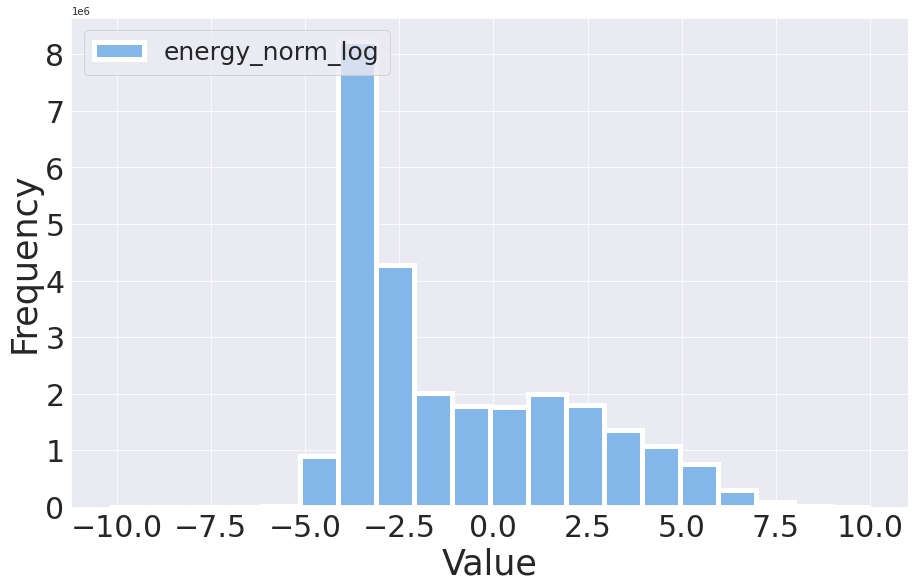

In [18]:
axes = pump_data_replica['energy_norm_log'].plot.hist(bins=20, 
                                               color=[color_1, color_2, color_3],
                                               #alpha=0.5,
                                               rot=0, 
                                               stacked=True,
                                               figsize=figsize, 
                                               fontsize=plot_fontsize, 
                                               linewidth=5)
#axes.ticklabel_format(useOffset=False, style='plain')
axes.legend(fontsize=legend_fontsize, loc = legend_loc) # loc=2
axes.set_xlabel('Value', fontsize=label_fontsize)
axes.set_ylabel('Frequency', fontsize=label_fontsize)

Text(0, 0.5, 'Frequency')

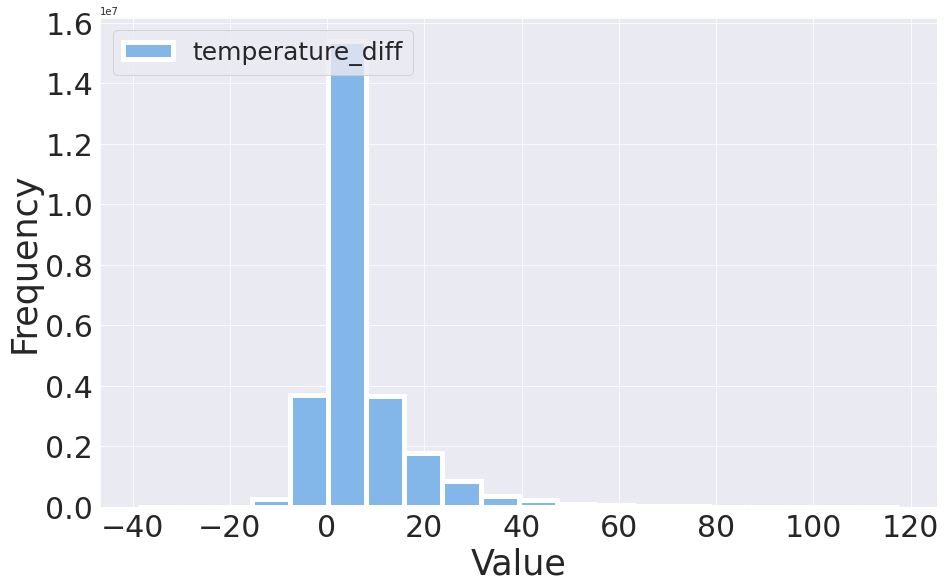

In [19]:
axes = pump_data_replica['temperature_diff'].plot.hist(bins=20, 
                                               color=[color_1, color_2, color_3],
                                               #alpha=0.5,
                                               rot=0, 
                                               stacked=True,
                                               figsize=figsize, 
                                               fontsize=plot_fontsize, 
                                               linewidth=5)
#axes.ticklabel_format(useOffset=False, style='plain')
axes.legend(fontsize=legend_fontsize, loc = legend_loc) # loc=2
axes.set_xlabel('Value', fontsize=label_fontsize)
axes.set_ylabel('Frequency', fontsize=label_fontsize)

Text(0, 0.5, 'Frequency')

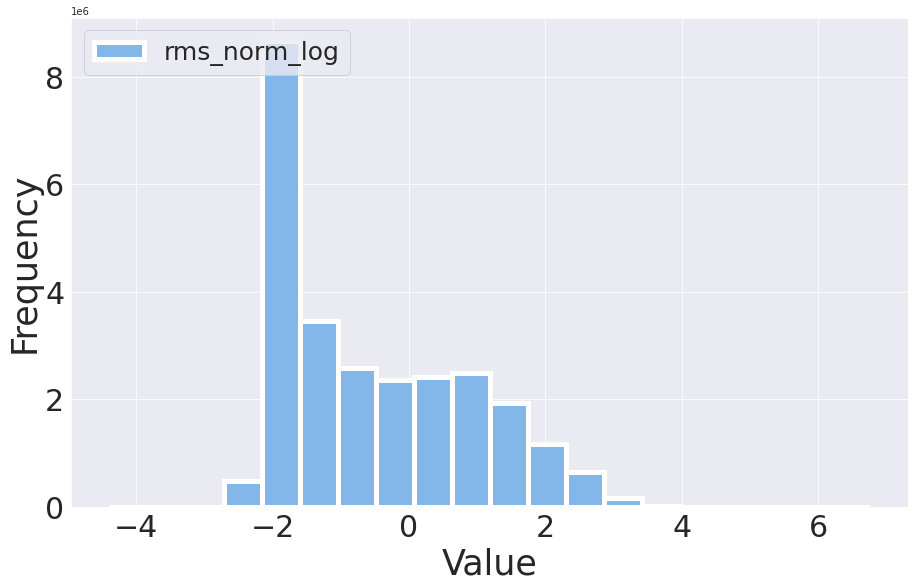

In [20]:
axes = pump_data_replica['rms_norm_log'].plot.hist(bins=20, 
                                               color=[color_1, color_2, color_3],
                                               #alpha=0.5,
                                               rot=0, 
                                               stacked=True,
                                               figsize=figsize, 
                                               fontsize=plot_fontsize, 
                                               linewidth=5)
#axes.ticklabel_format(useOffset=False, style='plain')
axes.legend(fontsize=legend_fontsize, loc = legend_loc) # loc=2
axes.set_xlabel('Value', fontsize=label_fontsize)
axes.set_ylabel('Frequency', fontsize=label_fontsize)

Text(0, 0.5, 'Frequency')

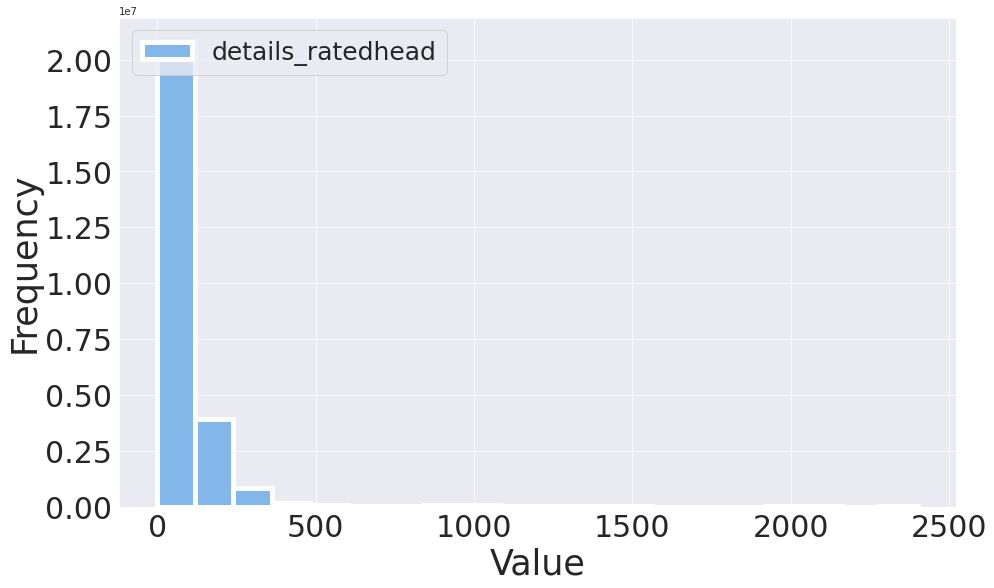

In [21]:
axes = pump_data_replica['details_ratedhead'].plot.hist(bins=20, 
                                               color=[color_1, color_2, color_3],
                                               #alpha=0.5,
                                               rot=0, 
                                               stacked=True,
                                               figsize=figsize, 
                                               fontsize=plot_fontsize, 
                                               linewidth=5)
#axes.ticklabel_format(useOffset=False, style='plain')
axes.legend(fontsize=legend_fontsize, loc = legend_loc) # loc=2
axes.set_xlabel('Value', fontsize=label_fontsize)
axes.set_ylabel('Frequency', fontsize=label_fontsize)

## Generate Data For Symbolic Metamodeling

In [22]:
pump_data_replica.head()

,energy_norm_log,temperature_diff,rms_norm_log,details_ratedhead,state
0,-4.642337,-0.585072,-2.831278,47.369469,1
1,-4.384410,-2.051363,-2.900545,120.240341,1
2,-5.047895,2.104730,-2.742720,92.577971,1
3,-4.962318,0.375291,-2.975236,75.714544,1
4,-5.082340,-1.878716,-2.900094,19.732252,1


In [23]:
data= pump_data_replica.sample(n=100_000)

X_data = data.drop(['state'], axis=1) #frac=0.1
y_data = data[['state']] #frac=0.1

In [24]:
X_data_scaled = np.empty_like(X_data.values.T)
scaler_list = []

for index, feature in enumerate(X_data.values.T):
    
    scaler = MinMaxScaler(feature_range=(1e-4, 1))
    scaler.fit(feature.reshape(-1, 1))
    scaler_list.append(scaler)
    
    feature_scaled = scaler.transform(feature.reshape(-1, 1)).ravel()
    
    X_data_scaled[index] = feature_scaled
    
X_data_scaled = pd.DataFrame(data= X_data_scaled.T, index=X_data.index, columns=list(X_data.columns))

In [25]:
#X_train_with_valid, X_test, y_train_with_valid, y_test = train_test_split(X_data, y_data, test_size=0.25, random_state=42)           
#X_train, X_valid, y_train, y_valid= train_test_split(X_train_with_valid, y_train_with_valid, test_size=0.25, random_state=42)   

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.25, random_state=42)  


#X_data_scaled = data_scaled.values 
#X_train_with_valid_scaled, X_test_scaled = train_test_split(X_data_scaled, test_size=0.25, random_state=42)           
#X_train_scaled, X_valid_scaled = train_test_split(X_train_with_valid_scaled, test_size=0.25, random_state=42)   

X_train_scaled, X_test_scaled = train_test_split(X_data_scaled, test_size=0.25, random_state=42)  


In [26]:
print(X_data.shape)
print(X_train.shape)
#print(X_valid.shape)
print(X_test.shape)
print()

print(X_data_scaled.shape)
print(X_train_scaled.shape)
#print(X_valid_scaled.shape)
print(X_test_scaled.shape)
print()

print(y_data.shape)
print(y_train.shape)
#print(y_valid.shape)
print(y_test.shape)

(100000, 4)
(75000, 4)
(25000, 4)

(100000, 4)
(75000, 4)
(25000, 4)

(100000, 1)
(75000, 1)
(25000, 1)


In [27]:
X_data.head()

,energy_norm_log,temperature_diff,rms_norm_log,details_ratedhead
13880350,-3.046441,3.142118,-2.153672,2.049436
13018525,-3.253409,1.100728,-1.834407,74.941685
22758968,0.151482,6.601620,0.143500,45.284839
26049008,-3.156811,7.770997,-1.850652,472.412949
4688620,0.485113,9.553305,1.172251,54.346425


In [28]:
X_data_scaled.head()

,energy_norm_log,temperature_diff,rms_norm_log,details_ratedhead
13880350,0.187314,0.199147,0.129700,0.000953
13018525,0.174365,0.183699,0.169780,0.031301
22758968,0.387395,0.225329,0.418088,0.018954
26049008,0.180409,0.234178,0.167741,0.196789
4688620,0.408269,0.247666,0.547238,0.022727


In [29]:
y_data.head()

,state
13880350,0
13018525,0
22758968,0
26049008,0
4688620,1


In [30]:
X_data.describe()

,energy_norm_log,temperature_diff,rms_norm_log,details_ratedhead
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,-0.926132,6.883145,-0.541237,110.873149
std,2.960861,9.571795,1.407717,191.522362
min,-6.038717,-23.159554,-3.186004,0.001450
25%,-3.366720,1.573012,-1.820031,38.097587
50%,-2.158722,4.893059,-0.923792,75.893879
75%,1.372991,8.750042,0.597593,114.209613
max,9.942830,108.964905,4.778744,2401.582094


In [31]:
X_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 13880350 to 8425222
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   energy_norm_log    100000 non-null  float64
 1   temperature_diff   100000 non-null  float64
 2   rms_norm_log       100000 non-null  float64
 3   details_ratedhead  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8 MB


In [32]:
accuracy_score(np.round(np.clip(data['energy_norm_log'].values * 1.631, 0, 1)).astype(int), data['state'].values)

0.90677

# Symbolic Metamodeling

In [33]:
metamodeling_hyperparams = {
    'num_iter': 100,#500,
    'batch_size': 128,
    'learning_rate': 0.001,        
    'dataset_size': 5000,
    'exact_expression': True,
    'flat_function': False,
    'polynomial_degree': 3,
    'early_stopping': 50,
    'restarts': 10,
}

return_error = True

symbolic_metamodeling = False
symbolic_metamodeling_adjusted = True

## Evaluate Model

In [34]:
y_test_random_forest = random_forest_model.predict(X_test)

accuracy_random_forest = accuracy_score(y_test, y_test_random_forest)
f1_random_forest = f1_score(y_test, y_test_random_forest)

print('Accuracy: '+ str(accuracy_random_forest))
print('F1 Score: '+ str(f1_random_forest))


Accuracy: 0.90676
F1 Score: 0.8706221901537438


In [35]:
if symbolic_metamodeling:
    from pysymbolic_original.algorithms.symbolic_metamodeling import symbolic_metamodel
    from pysymbolic_original.algorithms.symbolic_expressions import get_symbolic_model
    
    
    ## Symbolic Metamodeling
    if metamodeling_hyperparams['batch_size'] == None:
        metamodeling_hyperparams['batch_size'] = X_data.shape[0]

    metamodel = symbolic_metamodel(random_forest_model, 
                                   X_train[:metamodeling_hyperparams['dataset_size']], 
                                   mode="classification")

    metamodel.fit(num_iter=metamodeling_hyperparams['num_iter'], 
                  batch_size=metamodeling_hyperparams['batch_size'], 
                  learning_rate=metamodeling_hyperparams['learning_rate'])   


    if metamodeling_hyperparams['exact_expression']:
        metamodel_function = metamodel.exact_expression
        #print(metamodel_function)
    else:
        metamodel_function = metamodel.approx_expression
        #print(metamodel_function)


    y_test_metamodel = np.round(metamodel.evaluate(X_test)).astype(np.int64)
    y_test_model = random_forest_model.predict(X_test)

    accuracy_model_performance = accuracy_score(y_test, y_test_model)    
    accuracy_metamodel_performance = accuracy_score(y_test, y_test_metamodel) 

    accuracy_fidelity = accuracy_score(y_test_model, y_test_metamodel)     
    
    display(metamodel_function)
    
    print('Accuracy Random Forest Model:', accuracy_model_performance)
    print('Accuracy Symbolic Metaodel:', accuracy_metamodel_performance)
    
    print('Fidelity (Accuracy) Symbolic Metaodel - Random Forest Model:', accuracy_model_performance)

        


In [36]:
random_forest_model_scaled = deepcopy(random_forest_model)

for dt in random_forest_model_scaled.estimators_:

    n_nodes = dt.tree_.node_count
    children_left = dt.tree_.children_left
    children_right = dt.tree_.children_right
    feature = dt.tree_.feature
    threshold = dt.tree_.threshold

    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
    while len(stack) > 0:
        # `pop` ensures each node is only visited once
        node_id, depth = stack.pop()
        node_depth[node_id] = depth

        # If the left and right child of a node is not the same we have a split
        # node
        is_split_node = children_left[node_id] != children_right[node_id]
        # If a split node, append left and right children and depth to `stack`
        # so we can loop through them
        if is_split_node:
            stack.append((children_left[node_id], depth + 1))
            stack.append((children_right[node_id], depth + 1))
        else:
            is_leaves[node_id] = True

    for i in range(n_nodes):
        if not is_leaves[i]: 
            threshold[i] = scaler_list[int(feature[i])].transform(np.array([threshold[i]]).reshape(1, -1)).ravel()[0]

In [ ]:
if symbolic_metamodeling_adjusted:
    from pysymbolic_adjusted.algorithms.symbolic_metamodeling import symbolic_metamodel
    from pysymbolic_adjusted.algorithms.symbolic_expressions import get_symbolic_model    
    
    ## Symbolic Metamodeling
    if metamodeling_hyperparams['batch_size'] == None:
        metamodeling_hyperparams['batch_size'] = X_train_scaled.shape[0]

    metamodel = symbolic_metamodel(random_forest_model_scaled, #random_forest_model, #model,#
                                   X_train_scaled[:metamodeling_hyperparams['dataset_size']], #X_train, #X_train_abse,#
                                   mode="classification", 
                                   approximation_order = metamodeling_hyperparams['polynomial_degree'], 
                                   force_polynomial=metamodeling_hyperparams['flat_function'],
                                   verbosity=True,
                                   early_stopping=metamodeling_hyperparams['early_stopping'],
                                   restarts=metamodeling_hyperparams['restarts'])

    metamodel.fit(num_iter=metamodeling_hyperparams['num_iter'], 
                  batch_size=metamodeling_hyperparams['batch_size'], 
                  learning_rate=metamodeling_hyperparams['learning_rate'])    

    if metamodeling_hyperparams['exact_expression']:
        metamodel_function = metamodel.exact_expression
        #print(metamodel_function)
    else:
        metamodel_function = metamodel.approx_expression
        #print(metamodel_function)

    y_test_metamodel_eval = np.round(metamodel.evaluate(X_test_scaled)).astype(np.int64)
    
    y_test_metamodel = np.round(np.clip(calculate_function_values_from_sympy(metamodel_function, X_test_scaled), 0, 1)).astype(np.int64).reshape(-1,1)#np.round(calculate_function_values_from_sympy(metamodel_function, X_test)).astype(np.int64)

    
    y_test_model = random_forest_model_scaled.predict(X_test_scaled)

    accuracy_model_performance = accuracy_score(y_test, y_test_model)    
    accuracy_metamodel_performance = accuracy_score(y_test, y_test_metamodel) 
    accuracy_metamodel_performance_eval = accuracy_score(y_test, y_test_metamodel_eval) 
    
    accuracy_fidelity = accuracy_score(y_test_model, y_test_metamodel)     
    accuracy_fidelity_eval = accuracy_score(y_test_model, y_test_metamodel_eval)   
    
    f1_model_performance = f1_score(y_test, y_test_model)    
    f1_metamodel_performance = f1_score(y_test, y_test_metamodel) 
    f1_metamodel_performance_eval = f1_score(y_test, y_test_metamodel_eval) 
    
    f1_fidelity = f1_score(y_test_model, y_test_metamodel)     
    f1_fidelity_eval = f1_score(y_test_model, y_test_metamodel_eval)      
    
    display(metamodel_function)
    
    print('Accuracy Random Forest Model:', accuracy_model_performance)
    print('Accuracy Symbolic Metaodel:', accuracy_metamodel_performance)
    print('Accuracy Symbolic Metaodel Eval:', accuracy_metamodel_performance_eval)
    
    print('Fidelity (Accuracy) Symbolic Metaodel - Random Forest Model:', accuracy_fidelity)
    print('Fidelity (Accuracy) Symbolic Metaodel Eval - Random Forest Model:', accuracy_fidelity_eval)
    
    print('F1 Score Random Forest Model:', f1_model_performance)
    print('F1 Score Symbolic Metaodel:', f1_metamodel_performance)
    print('F1 Score Symbolic Metaodel Eval:', f1_metamodel_performance_eval)
    
    print('Fidelity (F1 Score) Symbolic Metaodel - Random Forest Model:', f1_fidelity)
    print('Fidelity (F1 Score) Symbolic Metaodel Eval - Random Forest Model:', f1_fidelity_eval)

2021-09-10 10:00:19.191207: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


---- Tuning the basis functions ----


basis function loop:   0%|          | 0/4 [00:00<?, ?it/s]

2021-09-10 10:00:21.800147: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-10.1/lib64:

restart loop:   0%|          | 0/11 [00:00<?, ?it/s]

iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

2021-09-10 10:00:21.800191: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-09-10 10:00:21.800218: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (dws-11): /proc/driver/nvidia/version does not exist


Iteration: 0 	--- Loss: 35.826
Iteration: 1 	--- Loss: 37.474
Iteration: 2 	--- Loss: 36.713
Iteration: 3 	--- Loss: 36.662
Iteration: 4 	--- Loss: 36.968
Iteration: 5 	--- Loss: 38.327
Iteration: 6 	--- Loss: 35.130
Iteration: 7 	--- Loss: 38.107
Iteration: 8 	--- Loss: 34.494
Iteration: 9 	--- Loss: 35.849
Iteration: 10 	--- Loss: 37.367
Iteration: 11 	--- Loss: 35.059
Iteration: 12 	--- Loss: 36.307
Iteration: 13 	--- Loss: 34.412
Iteration: 14 	--- Loss: 36.002
Iteration: 15 	--- Loss: 32.886
Iteration: 16 	--- Loss: 33.176
Iteration: 17 	--- Loss: 35.439
Iteration: 18 	--- Loss: 33.418
Iteration: 19 	--- Loss: 33.460
Iteration: 20 	--- Loss: 34.150
Iteration: 21 	--- Loss: 34.056
Iteration: 22 	--- Loss: 33.450
Iteration: 23 	--- Loss: 33.721
Iteration: 24 	--- Loss: 35.871
Iteration: 25 	--- Loss: 34.437
Iteration: 26 	--- Loss: 39.773
Iteration: 27 	--- Loss: 39.333
Iteration: 28 	--- Loss: 40.141
Iteration: 29 	--- Loss: 41.467
Iteration: 30 	--- Loss: 38.409
Iteration: 31 	---


restart loop:   9%|▉         | 1/11 [13:22<2:13:47, 802.77s/it]

Iteration: 127 	--- Loss: 31.297
Early Stopping requirement reached after 127 Iterations
New Global Minimum: 27.91507268855627


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 35.879
Iteration: 1 	--- Loss: 35.857
Iteration: 2 	--- Loss: 36.037
Iteration: 3 	--- Loss: 35.994
Iteration: 4 	--- Loss: 36.239
Iteration: 5 	--- Loss: 37.199
Iteration: 6 	--- Loss: 36.873
Iteration: 7 	--- Loss: 38.292
Iteration: 8 	--- Loss: 39.770
Iteration: 9 	--- Loss: 37.484
Iteration: 10 	--- Loss: 36.395
Iteration: 11 	--- Loss: 36.824
Iteration: 12 	--- Loss: 36.731
Iteration: 13 	--- Loss: 38.283
Iteration: 14 	--- Loss: 36.194
Iteration: 15 	--- Loss: 36.227
Iteration: 16 	--- Loss: 36.188
Iteration: 17 	--- Loss: 34.557
Iteration: 18 	--- Loss: 36.889
Iteration: 19 	--- Loss: 35.892
Iteration: 20 	--- Loss: 36.214
Iteration: 21 	--- Loss: 36.749
Iteration: 22 	--- Loss: 34.620
Iteration: 23 	--- Loss: 36.050
Iteration: 24 	--- Loss: 35.610
Iteration: 25 	--- Loss: 33.672
Iteration: 26 	--- Loss: 35.077
Iteration: 27 	--- Loss: 35.093
Iteration: 28 	--- Loss: 35.079
Iteration: 29 	--- Loss: 36.541
Iteration: 30 	--- Loss: 36.188
Iteration: 31 	---


restart loop:  18%|█▊        | 2/11 [21:15<1:31:18, 608.78s/it]

Iteration: 92 	--- Loss: 34.290
Early Stopping requirement reached after 92 Iterations


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 34.558
Iteration: 1 	--- Loss: 37.902
Iteration: 2 	--- Loss: 39.208
Iteration: 3 	--- Loss: 37.631
Iteration: 4 	--- Loss: 37.305
Iteration: 5 	--- Loss: 38.008
Iteration: 6 	--- Loss: 38.590
Iteration: 7 	--- Loss: 36.522
Iteration: 8 	--- Loss: 36.205
Iteration: 9 	--- Loss: 36.053
Iteration: 10 	--- Loss: 34.107
Iteration: 11 	--- Loss: 36.799
Iteration: 12 	--- Loss: 35.065
Iteration: 13 	--- Loss: 34.829
Iteration: 14 	--- Loss: 36.377
Iteration: 15 	--- Loss: 34.753
Iteration: 16 	--- Loss: 36.543
Iteration: 17 	--- Loss: 35.699
Iteration: 18 	--- Loss: 33.637
Iteration: 19 	--- Loss: 34.263
Iteration: 20 	--- Loss: 31.305
Iteration: 21 	--- Loss: 33.602
Iteration: 22 	--- Loss: 34.336
Iteration: 23 	--- Loss: 33.243
Iteration: 24 	--- Loss: 45.479
Iteration: 25 	--- Loss: 52.792
Iteration: 26 	--- Loss: 60.502
Iteration: 27 	--- Loss: 64.933
Iteration: 28 	--- Loss: 41.495
Iteration: 29 	--- Loss: 37.417
Iteration: 30 	--- Loss: 42.659
Iteration: 31 	---


restart loop:  27%|██▋       | 3/11 [49:49<2:28:25, 1113.17s/it]

Iteration: 357 	--- Loss: 16.634
Early Stopping requirement reached after 357 Iterations
New Global Minimum: 13.499721194345828


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 36.459
Iteration: 1 	--- Loss: 38.368
Iteration: 2 	--- Loss: 37.007
Iteration: 3 	--- Loss: 35.922
Iteration: 4 	--- Loss: 35.126
Iteration: 5 	--- Loss: 34.601
Iteration: 6 	--- Loss: 38.586
Iteration: 7 	--- Loss: 37.851
Iteration: 8 	--- Loss: 38.437
Iteration: 9 	--- Loss: 38.283
Iteration: 10 	--- Loss: 37.977
Iteration: 11 	--- Loss: 39.431
Iteration: 12 	--- Loss: 36.066
Iteration: 13 	--- Loss: 36.196
Iteration: 14 	--- Loss: 41.054
Iteration: 15 	--- Loss: 38.338
Iteration: 16 	--- Loss: 38.515
Wrong c Value: -0.010034777
te can't convert complex to float
function_value 2.12268380432103e-13 - 1.46364128231014e-13*I
function 1.00550745101054e-9*x**3.80785*exp(3.80785*I*pi)*hyper((1.0, 1.0), (5.01138,), 0.0100347772240639*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 7.90580911801744e-11 - 5.45124458557568e-11*I
function 1.00550745101054e-9*x**3.80785*exp(3.80785*I*pi)*hyper((1.0, 1.0), (5.01138,),


restart loop:  36%|███▋      | 4/11 [51:11<1:22:24, 706.38s/it] 

te can't convert complex to float
function_value 8.94301750341792e-12 - 6.1664245893709e-12*I
function 1.00550745101054e-9*x**3.80785*exp(3.80785*I*pi)*hyper((1.0, 1.0), (5.01138,), 0.0100347772240639*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 6.81910476300145e-13 - 4.70193592621255e-13*I
function 1.00550745101054e-9*x**3.80785*exp(3.80785*I*pi)*hyper((1.0, 1.0), (5.01138,), 0.0100347772240639*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 5.4540299576236e-13 - 3.7606841794732e-13*I
function 1.00550745101054e-9*x**3.80785*exp(3.80785*I*pi)*hyper((1.0, 1.0), (5.01138,), 0.0100347772240639*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 1.4760226764193e-10 - 1.01775295898308e-10*I
function 1.00550745101054e-9*x**3.80785*exp(3.80785*I*pi)*hyper((1.0, 1.0), (5.01138,), 0.0100347772240639*x*exp_polar(2*I*pi))
function_vars

iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 37.631
Iteration: 1 	--- Loss: 37.082
Iteration: 2 	--- Loss: 36.027
Iteration: 3 	--- Loss: 36.485
Iteration: 4 	--- Loss: 39.619
Iteration: 5 	--- Loss: 38.313
Iteration: 6 	--- Loss: 36.709
Iteration: 7 	--- Loss: 36.521
Iteration: 8 	--- Loss: 34.296
Iteration: 9 	--- Loss: 37.839
Iteration: 10 	--- Loss: 35.652
Iteration: 11 	--- Loss: 37.561
Iteration: 12 	--- Loss: 37.007
Iteration: 13 	--- Loss: 37.751
Iteration: 14 	--- Loss: 34.285
Iteration: 15 	--- Loss: 33.696
Iteration: 16 	--- Loss: 36.017
Iteration: 17 	--- Loss: 33.947
Iteration: 18 	--- Loss: 34.732
Iteration: 19 	--- Loss: 36.615
Iteration: 20 	--- Loss: 31.887
Iteration: 21 	--- Loss: 33.996
Iteration: 22 	--- Loss: 33.655
Iteration: 23 	--- Loss: 31.978
Iteration: 24 	--- Loss: 33.045
Iteration: 25 	--- Loss: 35.155
Iteration: 26 	--- Loss: 64.538
Iteration: 27 	--- Loss: 81.060
Iteration: 28 	--- Loss: 76.564
Iteration: 29 	--- Loss: 40.199
Iteration: 30 	--- Loss: 43.269
Iteration: 31 	---


restart loop:  45%|████▌     | 5/11 [1:00:34<1:05:27, 654.61s/it]

Iteration: 99 	--- Loss: 22.246
Early Stopping requirement reached after 99 Iterations


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 37.674
Iteration: 1 	--- Loss: 39.198
Iteration: 2 	--- Loss: 38.370
Iteration: 3 	--- Loss: 36.814
Iteration: 4 	--- Loss: 36.323
Iteration: 5 	--- Loss: 35.195
Iteration: 6 	--- Loss: 36.429
Iteration: 7 	--- Loss: 33.662
Iteration: 8 	--- Loss: 32.888
Iteration: 9 	--- Loss: 33.614
Iteration: 10 	--- Loss: 36.714
Iteration: 11 	--- Loss: 32.753
Iteration: 12 	--- Loss: 37.845
Iteration: 13 	--- Loss: 52.197
Iteration: 14 	--- Loss: 68.770
Iteration: 15 	--- Loss: 70.016
Iteration: 16 	--- Loss: 41.195
Iteration: 17 	--- Loss: 41.185
Iteration: 18 	--- Loss: 44.328
Iteration: 19 	--- Loss: 41.377
Iteration: 20 	--- Loss: 40.622
Iteration: 21 	--- Loss: 36.429
Iteration: 22 	--- Loss: 38.071
Iteration: 23 	--- Loss: 38.426
Iteration: 24 	--- Loss: 41.968
Iteration: 25 	--- Loss: 42.840
Iteration: 26 	--- Loss: 43.242
Iteration: 27 	--- Loss: 43.996
Iteration: 28 	--- Loss: 43.591
Iteration: 29 	--- Loss: 42.281
Iteration: 30 	--- Loss: 36.448
Iteration: 31 	---


restart loop:  55%|█████▍    | 6/11 [1:27:46<1:22:14, 986.93s/it]

Iteration: 200 	--- Loss: 18.340
Early Stopping requirement reached after 200 Iterations


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 38.042
Iteration: 1 	--- Loss: 36.542
Iteration: 2 	--- Loss: 37.406
Iteration: 3 	--- Loss: 37.712
Iteration: 4 	--- Loss: 37.929
Iteration: 5 	--- Loss: 35.932
Iteration: 6 	--- Loss: 36.258
Iteration: 7 	--- Loss: 35.963
Iteration: 8 	--- Loss: 35.642
Iteration: 9 	--- Loss: 36.116
Iteration: 10 	--- Loss: 36.712
Iteration: 11 	--- Loss: 35.587
Iteration: 12 	--- Loss: 34.962
Iteration: 13 	--- Loss: 34.344
Iteration: 14 	--- Loss: 35.322
Iteration: 15 	--- Loss: 33.040
Iteration: 16 	--- Loss: 35.352
Iteration: 17 	--- Loss: 34.638
Iteration: 18 	--- Loss: 35.483
Iteration: 19 	--- Loss: 32.706
Iteration: 20 	--- Loss: 35.626
Iteration: 21 	--- Loss: 47.999
Iteration: 22 	--- Loss: 68.755
Iteration: 23 	--- Loss: 65.618
Iteration: 24 	--- Loss: 35.374
Iteration: 25 	--- Loss: 44.432
Iteration: 26 	--- Loss: 43.220
Iteration: 27 	--- Loss: 37.383
Iteration: 28 	--- Loss: 38.028
Iteration: 29 	--- Loss: 35.012
Iteration: 30 	--- Loss: 38.881
Iteration: 31 	---


restart loop:  64%|██████▎   | 7/11 [1:44:27<1:06:05, 991.37s/it]

Iteration: 88 	--- Loss: 33.277
Early Stopping requirement reached after 88 Iterations


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 35.017
Iteration: 1 	--- Loss: 36.157
Iteration: 2 	--- Loss: 38.386
Iteration: 3 	--- Loss: 36.264
Iteration: 4 	--- Loss: 36.492
Iteration: 5 	--- Loss: 34.407
Iteration: 6 	--- Loss: 35.726
Iteration: 7 	--- Loss: 33.263
Iteration: 8 	--- Loss: 37.109
Iteration: 9 	--- Loss: 34.293
Iteration: 10 	--- Loss: 34.760
Iteration: 11 	--- Loss: 33.114
Iteration: 12 	--- Loss: 35.547
Iteration: 13 	--- Loss: 49.372
Iteration: 14 	--- Loss: 74.419
Iteration: 15 	--- Loss: 94.594
Iteration: 16 	--- Loss: 46.617
Iteration: 17 	--- Loss: 39.676
Iteration: 18 	--- Loss: 43.255
Iteration: 19 	--- Loss: 40.593
Iteration: 20 	--- Loss: 36.126
Iteration: 21 	--- Loss: 34.774
Iteration: 22 	--- Loss: 38.416
Iteration: 23 	--- Loss: 37.219
Iteration: 24 	--- Loss: 44.024
Iteration: 25 	--- Loss: 38.851
Iteration: 26 	--- Loss: 38.578
Iteration: 27 	--- Loss: 32.827
Iteration: 28 	--- Loss: 24.171
Iteration: 29 	--- Loss: 17.582
Iteration: 30 	--- Loss: 16.118
Iteration: 31 	---


restart loop:  73%|███████▎  | 8/11 [2:17:19<1:05:11, 1303.68s/it]

Iteration: 159 	--- Loss: 17.427
Early Stopping requirement reached after 159 Iterations


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 37.854
Iteration: 1 	--- Loss: 34.887
Iteration: 2 	--- Loss: 37.316
Iteration: 3 	--- Loss: 37.339
Iteration: 4 	--- Loss: 37.116
Iteration: 5 	--- Loss: 38.944
Iteration: 6 	--- Loss: 38.468
Iteration: 7 	--- Loss: 35.221
Iteration: 8 	--- Loss: 41.156
Iteration: 9 	--- Loss: 35.324
Iteration: 10 	--- Loss: 36.180
Iteration: 11 	--- Loss: 37.370
Iteration: 12 	--- Loss: 38.364
Iteration: 13 	--- Loss: 37.261
Iteration: 14 	--- Loss: 35.193
Iteration: 15 	--- Loss: 36.900
Iteration: 16 	--- Loss: 36.591
Iteration: 17 	--- Loss: 37.823
Iteration: 18 	--- Loss: 39.159
Iteration: 19 	--- Loss: 37.498
Iteration: 20 	--- Loss: 37.119
Iteration: 21 	--- Loss: 38.157
Iteration: 22 	--- Loss: 39.641
Iteration: 23 	--- Loss: 35.547
Iteration: 24 	--- Loss: 38.873
Iteration: 25 	--- Loss: 39.226
Iteration: 26 	--- Loss: 35.162
Iteration: 27 	--- Loss: 37.981
Iteration: 28 	--- Loss: 36.155
Iteration: 29 	--- Loss: 36.832
Iteration: 30 	--- Loss: 37.347
Iteration: 31 	---


restart loop:  82%|████████▏ | 9/11 [2:47:28<48:43, 1461.75s/it]  

Iteration: 164 	--- Loss: 16.353
Early Stopping requirement reached after 164 Iterations


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 36.115
Iteration: 1 	--- Loss: 38.119
Iteration: 2 	--- Loss: 34.152
Iteration: 3 	--- Loss: 35.520
Iteration: 4 	--- Loss: 37.283
Iteration: 5 	--- Loss: 38.025
Iteration: 6 	--- Loss: 34.867
Iteration: 7 	--- Loss: 33.100
Iteration: 8 	--- Loss: 35.365
Iteration: 9 	--- Loss: 37.071
Iteration: 10 	--- Loss: 34.203
Iteration: 11 	--- Loss: 33.333
Iteration: 12 	--- Loss: 35.834
Iteration: 13 	--- Loss: 35.115
Iteration: 14 	--- Loss: 32.885
Iteration: 15 	--- Loss: 34.549
Iteration: 16 	--- Loss: 50.467
Iteration: 17 	--- Loss: 115.621
Iteration: 18 	--- Loss: 114.677
Iteration: 19 	--- Loss: 62.307
Iteration: 20 	--- Loss: 41.246
Iteration: 21 	--- Loss: 47.158
Iteration: 22 	--- Loss: 37.218
Iteration: 23 	--- Loss: 34.270
Iteration: 24 	--- Loss: 39.117
Iteration: 25 	--- Loss: 42.635
Iteration: 26 	--- Loss: 39.810
Iteration: 27 	--- Loss: 32.920
Iteration: 28 	--- Loss: 25.312
Iteration: 29 	--- Loss: 26.105
Iteration: 30 	--- Loss: 55.860
Iteration: 31 	-


restart loop:  91%|█████████ | 10/11 [3:06:25<22:41, 1361.32s/it]

Iteration: 88 	--- Loss: 36.030
Early Stopping requirement reached after 88 Iterations


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 37.906
Iteration: 1 	--- Loss: 37.406
Iteration: 2 	--- Loss: 35.634
Iteration: 3 	--- Loss: 35.143
Iteration: 4 	--- Loss: 38.229
Iteration: 5 	--- Loss: 37.520
Iteration: 6 	--- Loss: 38.132
Iteration: 7 	--- Loss: 36.070
Iteration: 8 	--- Loss: 36.423
Iteration: 9 	--- Loss: 33.109
Iteration: 10 	--- Loss: 35.265
Iteration: 11 	--- Loss: 35.141
Iteration: 12 	--- Loss: 33.645
Iteration: 13 	--- Loss: 34.015
Iteration: 14 	--- Loss: 33.690
Iteration: 15 	--- Loss: 33.229
Iteration: 16 	--- Loss: 39.913
Iteration: 17 	--- Loss: 64.289
Iteration: 18 	--- Loss: 95.663
Iteration: 19 	--- Loss: 64.667
Iteration: 20 	--- Loss: 36.109
Iteration: 21 	--- Loss: 49.725
Iteration: 22 	--- Loss: 42.701
Iteration: 23 	--- Loss: 39.738
Iteration: 24 	--- Loss: 38.407
Iteration: 25 	--- Loss: 36.126
Iteration: 26 	--- Loss: 38.529
Iteration: 27 	--- Loss: 36.852
Iteration: 28 	--- Loss: 38.472
Iteration: 29 	--- Loss: 38.455
Iteration: 30 	--- Loss: 40.343
Iteration: 31 	---


restart loop: 100%|██████████| 11/11 [3:24:16<00:00, 1114.24s/it]


Iteration: 96 	--- Loss: 22.447
Early Stopping requirement reached after 96 Iterations
return abc -1.6678402 -0.1788936 1.1630704



restart loop:   0%|          | 0/11 [00:00<?, ?it/s]

iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 39.307
Iteration: 1 	--- Loss: 35.523
Iteration: 2 	--- Loss: 35.689
Iteration: 3 	--- Loss: 38.715
Iteration: 4 	--- Loss: 35.601
Iteration: 5 	--- Loss: 38.625
Iteration: 6 	--- Loss: 37.059
Iteration: 7 	--- Loss: 38.954
Iteration: 8 	--- Loss: 37.807
Iteration: 9 	--- Loss: 36.951
Iteration: 10 	--- Loss: 36.517
Iteration: 11 	--- Loss: 38.728
Iteration: 12 	--- Loss: 37.887
Iteration: 13 	--- Loss: 36.236
Iteration: 14 	--- Loss: 37.937
Iteration: 15 	--- Loss: 37.942
Iteration: 16 	--- Loss: 38.838
Iteration: 17 	--- Loss: 40.123
Iteration: 18 	--- Loss: 38.143
Iteration: 19 	--- Loss: 37.399
Iteration: 20 	--- Loss: 37.852
Iteration: 21 	--- Loss: 37.414
Iteration: 22 	--- Loss: 35.629
Iteration: 23 	--- Loss: 35.894
Iteration: 24 	--- Loss: 36.241
Iteration: 25 	--- Loss: 37.847
Iteration: 26 	--- Loss: 38.053
Iteration: 27 	--- Loss: 36.985
Wrong c Value: -0.007252301
te can't convert complex to float
function_value -3.0528968110593e-10 - 5.080403999641


restart loop:   9%|▉         | 1/11 [04:24<44:00, 264.02s/it]

te can't convert complex to float
function_value -2.00764264954767e-9 - 3.34096970119148e-10*I
function 4.34151607496476e-8*x**3.05249*exp(3.05249*I*pi)*hyper((1.0, 1.0), (4.09671,), 0.00725230108946562*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -8.24272034902524e-10 - 1.37169226543839e-10*I
function 4.34151607496476e-8*x**3.05249*exp(3.05249*I*pi)*hyper((1.0, 1.0), (4.09671,), 0.00725230108946562*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -3.06032155377782e-10 - 5.09275970471065e-11*I
function 4.34151607496476e-8*x**3.05249*exp(3.05249*I*pi)*hyper((1.0, 1.0), (4.09671,), 0.00725230108946562*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
Iteration: 28 	--- Loss: inf
BREAK tune_single_dim
func_true 1.7976931348623157e+308
y[batch_index] -6.918928126733585
a_new, b_new, c_new nan nan nan
best_parameters abc 2.18034 0.82877696 0.8306291
New Global Minimum: 35.5231

iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 36.978
Iteration: 1 	--- Loss: 38.563
Iteration: 2 	--- Loss: 39.735
Iteration: 3 	--- Loss: 37.868
Iteration: 4 	--- Loss: 36.704
Iteration: 5 	--- Loss: 38.559
Iteration: 6 	--- Loss: 39.514
Iteration: 7 	--- Loss: 36.625
Iteration: 8 	--- Loss: 35.874
Iteration: 9 	--- Loss: 38.007
Iteration: 10 	--- Loss: 36.510
Iteration: 11 	--- Loss: 37.054
Iteration: 12 	--- Loss: 37.443
Iteration: 13 	--- Loss: 35.648
Iteration: 14 	--- Loss: 37.925
Iteration: 15 	--- Loss: 35.392
Iteration: 16 	--- Loss: 38.056
Iteration: 17 	--- Loss: 36.521
Iteration: 18 	--- Loss: 35.515
Iteration: 19 	--- Loss: 37.810
Iteration: 20 	--- Loss: 34.999
Iteration: 21 	--- Loss: 35.187
Iteration: 22 	--- Loss: 36.222
Iteration: 23 	--- Loss: 36.777
Iteration: 24 	--- Loss: 36.417
Iteration: 25 	--- Loss: 36.631
Iteration: 26 	--- Loss: 36.991
Iteration: 27 	--- Loss: 37.992
Iteration: 28 	--- Loss: 34.343
Iteration: 29 	--- Loss: 34.767
Iteration: 30 	--- Loss: 34.166
Iteration: 31 	---


restart loop:  18%|█▊        | 2/11 [18:08<1:29:03, 593.71s/it]

Iteration: 87 	--- Loss: 28.408
Early Stopping requirement reached after 87 Iterations
New Global Minimum: 26.003284342322143


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 36.756
Iteration: 1 	--- Loss: 36.362
Iteration: 2 	--- Loss: 37.810
Iteration: 3 	--- Loss: 37.666
Iteration: 4 	--- Loss: 39.219
Iteration: 5 	--- Loss: 38.098
Iteration: 6 	--- Loss: 37.713
Iteration: 7 	--- Loss: 38.935
Iteration: 8 	--- Loss: 36.993
Iteration: 9 	--- Loss: 34.720
Iteration: 10 	--- Loss: 37.148
Iteration: 11 	--- Loss: 36.206
Iteration: 12 	--- Loss: 35.993
Iteration: 13 	--- Loss: 35.152
Iteration: 14 	--- Loss: 34.599
Iteration: 15 	--- Loss: 37.336
Iteration: 16 	--- Loss: 34.042
Iteration: 17 	--- Loss: 35.746
Iteration: 18 	--- Loss: 32.943
Iteration: 19 	--- Loss: 31.110
Iteration: 20 	--- Loss: 29.328
Iteration: 21 	--- Loss: 31.294
Iteration: 22 	--- Loss: 30.774
Iteration: 23 	--- Loss: 26.248
Iteration: 24 	--- Loss: 28.309
Iteration: 25 	--- Loss: 26.843
Iteration: 26 	--- Loss: 26.572
Iteration: 27 	--- Loss: 28.893
Iteration: 28 	--- Loss: 27.897
Iteration: 29 	--- Loss: 27.038
Iteration: 30 	--- Loss: 29.080
Iteration: 31 	---


restart loop:  27%|██▋       | 3/11 [49:06<2:36:07, 1170.94s/it]

Iteration: 198 	--- Loss: 27.056
Early Stopping requirement reached after 198 Iterations
New Global Minimum: 25.57008120029174


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 37.883
Iteration: 1 	--- Loss: 39.245
Iteration: 2 	--- Loss: 37.878
Iteration: 3 	--- Loss: 38.835
Iteration: 4 	--- Loss: 37.185
Iteration: 5 	--- Loss: 38.636
Iteration: 6 	--- Loss: 35.826
Iteration: 7 	--- Loss: 38.726
Iteration: 8 	--- Loss: 36.944
Iteration: 9 	--- Loss: 37.595
Iteration: 10 	--- Loss: 38.598
Iteration: 11 	--- Loss: 36.070
Iteration: 12 	--- Loss: 36.150
Iteration: 13 	--- Loss: 36.552
Iteration: 14 	--- Loss: 34.134
Iteration: 15 	--- Loss: 34.707
Iteration: 16 	--- Loss: 33.298
Iteration: 17 	--- Loss: 33.273
Iteration: 18 	--- Loss: 30.201
Iteration: 19 	--- Loss: 48.365
Iteration: 20 	--- Loss: 26.870
Iteration: 21 	--- Loss: 28.817
Iteration: 22 	--- Loss: 30.167
Iteration: 23 	--- Loss: 31.011
Iteration: 24 	--- Loss: 32.254
Iteration: 25 	--- Loss: 33.238
Iteration: 26 	--- Loss: 34.254
Iteration: 27 	--- Loss: 35.383
Iteration: 28 	--- Loss: 32.786
Iteration: 29 	--- Loss: 34.514
Iteration: 30 	--- Loss: 36.135
Iteration: 31 	---


restart loop:  36%|███▋      | 4/11 [1:13:58<2:31:24, 1297.77s/it]

Iteration: 163 	--- Loss: 27.755
Early Stopping requirement reached after 163 Iterations
New Global Minimum: 24.408409181405144


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 35.863
Iteration: 1 	--- Loss: 35.879
Iteration: 2 	--- Loss: 41.012
Iteration: 3 	--- Loss: 36.119
Iteration: 4 	--- Loss: 37.372
Iteration: 5 	--- Loss: 36.617
Wrong c Value: -0.14808214
te can't convert complex to float
function_value -8.99477747482224e-6 - 1.31227278127899e-5*I
function 0.00198215397628037*x**3.30873*exp(3.30873*I*pi)*hyper((1.0, 1.0), (1.24055,), 0.148082137107849*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -1.46987746725369e-5 - 2.14444459297803e-5*I
function 0.00198215397628037*x**3.30873*exp(3.30873*I*pi)*hyper((1.0, 1.0), (1.24055,), 0.148082137107849*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -4.77875826462454e-6 - 6.97186163474569e-6*I
function 0.00198215397628037*x**3.30873*exp(3.30873*I*pi)*hyper((1.0, 1.0), (1.24055,), 0.148082137107849*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex 


restart loop:  45%|████▌     | 5/11 [1:14:56<1:25:04, 850.69s/it] 


function_vars [x] <class 'list'>
te can't convert complex to float
function_value -8.76235688487666e-6 - 1.27836430329294e-5*I
function 0.00198215397628037*x**3.30873*exp(3.30873*I*pi)*hyper((1.0, 1.0), (1.24055,), 0.148082137107849*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -2.72443703974102e-5 - 3.97475599765306e-5*I
function 0.00198215397628037*x**3.30873*exp(3.30873*I*pi)*hyper((1.0, 1.0), (1.24055,), 0.148082137107849*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -3.93317026495579e-6 - 5.73821008611372e-6*I
function 0.00198215397628037*x**3.30873*exp(3.30873*I*pi)*hyper((1.0, 1.0), (1.24055,), 0.148082137107849*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -4.87202917365521e-6 - 7.10793712471607e-6*I
function 0.00198215397628037*x**3.30873*exp(3.30873*I*pi)*hyper((1.0, 1.0), (1.24055,), 0.148082137107849*x*ex

iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 36.646
Iteration: 1 	--- Loss: 37.264
Iteration: 2 	--- Loss: 38.420
Iteration: 3 	--- Loss: 38.909
Iteration: 4 	--- Loss: 38.925
Iteration: 5 	--- Loss: 36.760
Wrong c Value: -0.0038862377
te can't convert complex to float
function_value -3.85850103194298e-10 - 2.92158995630897e-10*I
function 1.90653302257251e-8*x**3.20629*exp(3.20629*I*pi)*hyper((1.0, 1.0), (1.03753,), 0.00388623774051666*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -1.12208826162269e-10 - 8.4962574017979e-11*I
function 1.90653302257251e-8*x**3.20629*exp(3.20629*I*pi)*hyper((1.0, 1.0), (1.03753,), 0.00388623774051666*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -1.55943220814754e-10 - 1.18077497949362e-10*I
function 1.90653302257251e-8*x**3.20629*exp(3.20629*I*pi)*hyper((1.0, 1.0), (1.03753,), 0.00388623774051666*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't con


restart loop:  55%|█████▍    | 6/11 [1:15:53<48:24, 580.85s/it]  

te can't convert complex to float
function_value -8.15560432455405e-10 - 6.17528192554315e-10*I
function 1.90653302257251e-8*x**3.20629*exp(3.20629*I*pi)*hyper((1.0, 1.0), (1.03753,), 0.00388623774051666*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -7.96137271536368e-11 - 6.02821312501401e-11*I
function 1.90653302257251e-8*x**3.20629*exp(3.20629*I*pi)*hyper((1.0, 1.0), (1.03753,), 0.00388623774051666*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -9.25023370293962e-11 - 7.00411627631734e-11*I
function 1.90653302257251e-8*x**3.20629*exp(3.20629*I*pi)*hyper((1.0, 1.0), (1.03753,), 0.00388623774051666*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -2.61081174548441e-10 - 1.97686130190815e-10*I
function 1.90653302257251e-8*x**3.20629*exp(3.20629*I*pi)*hyper((1.0, 1.0), (1.03753,), 0.00388623774051666*x*exp_polar(2*I*pi))
f

iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 38.412
Iteration: 1 	--- Loss: 38.568
Iteration: 2 	--- Loss: 39.105
Iteration: 3 	--- Loss: 36.535
Iteration: 4 	--- Loss: 35.129
Iteration: 5 	--- Loss: 40.284
Wrong c Value: -0.02415283
te can't convert complex to float
function_value -1.15545252153395e-6 + 8.4720323004189e-7*I
function 3.28637080435144e-5*x**2.79861*exp(2.79861*I*pi)*hyper((1.0, 1.0), (1.24485,), 0.0241528302431107*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -2.41327536703505e-7 + 1.76946663565056e-7*I
function 3.28637080435144e-5*x**2.79861*exp(2.79861*I*pi)*hyper((1.0, 1.0), (1.24485,), 0.0241528302431107*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -6.88295270031329e-7 + 5.04673247169824e-7*I
function 3.28637080435144e-5*x**2.79861*exp(2.79861*I*pi)*hyper((1.0, 1.0), (1.24485,), 0.0241528302431107*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert comple


restart loop:  64%|██████▎   | 7/11 [1:16:49<27:17, 409.40s/it]

te can't convert complex to float
function_value -1.04679670655681e-6 + 7.67534394069937e-7*I
function 3.28637080435144e-5*x**2.79861*exp(2.79861*I*pi)*hyper((1.0, 1.0), (1.24485,), 0.0241528302431107*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -1.18815109148112e-7 + 8.71178541498413e-8*I
function 3.28637080435144e-5*x**2.79861*exp(2.79861*I*pi)*hyper((1.0, 1.0), (1.24485,), 0.0241528302431107*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -3.29518766498624e-7 + 2.41610415083465e-7*I
function 3.28637080435144e-5*x**2.79861*exp(2.79861*I*pi)*hyper((1.0, 1.0), (1.24485,), 0.0241528302431107*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
Iteration: 6 	--- Loss: inf
BREAK tune_single_dim
func_true 1.7976931348623157e+308
y[batch_index] 4.303643525379705
a_new, b_new, c_new nan nan nan
best_parameters abc 2.5603595 2.3490334 0.22315538


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 40.921
Iteration: 1 	--- Loss: 37.749
Iteration: 2 	--- Loss: 37.055
Iteration: 3 	--- Loss: 35.651
Iteration: 4 	--- Loss: 35.648
Iteration: 5 	--- Loss: 34.968
Iteration: 6 	--- Loss: 36.550
Iteration: 7 	--- Loss: 37.174
Iteration: 8 	--- Loss: 34.491
Iteration: 9 	--- Loss: 36.921
Iteration: 10 	--- Loss: 36.068
Iteration: 11 	--- Loss: 34.120
Iteration: 12 	--- Loss: 35.214
Iteration: 13 	--- Loss: 34.875
Iteration: 14 	--- Loss: 33.901
Iteration: 15 	--- Loss: 33.089
Iteration: 16 	--- Loss: 31.136
Iteration: 17 	--- Loss: 86.954
Iteration: 18 	--- Loss: 27.869
Iteration: 19 	--- Loss: 31.289
Iteration: 20 	--- Loss: 31.618
Iteration: 21 	--- Loss: 34.771
Iteration: 22 	--- Loss: 34.406
Iteration: 23 	--- Loss: 36.503
Iteration: 24 	--- Loss: 35.915
Iteration: 25 	--- Loss: 34.651
Iteration: 26 	--- Loss: 33.902
Iteration: 27 	--- Loss: 36.934
Iteration: 28 	--- Loss: 36.869
Iteration: 29 	--- Loss: 37.402
Iteration: 30 	--- Loss: 36.340
Iteration: 31 	---


restart loop:  73%|███████▎  | 8/11 [1:25:14<21:58, 439.60s/it]

Iteration: 69 	--- Loss: 36.353
Early Stopping requirement reached after 69 Iterations


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 37.283
Iteration: 1 	--- Loss: 38.812
Iteration: 2 	--- Loss: 37.290
Iteration: 3 	--- Loss: 37.596
Iteration: 4 	--- Loss: 37.688
Iteration: 5 	--- Loss: 38.448
Wrong c Value: -0.1324291
te can't convert complex to float
function_value -4.74191237538551e-5 + 2.56725766437659e-5*I
function 0.00345115716723392*x**2.84205*exp(2.84205*I*pi)*hyper((1.0, 1.0), (1.17191,), 0.132429093122482*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -8.4279680735746e-5 + 4.56287757325895e-5*I
function 0.00345115716723392*x**2.84205*exp(2.84205*I*pi)*hyper((1.0, 1.0), (1.17191,), 0.132429093122482*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -4.76039097374528e-5 + 2.57726192415843e-5*I
function 0.00345115716723392*x**2.84205*exp(2.84205*I*pi)*hyper((1.0, 1.0), (1.17191,), 0.132429093122482*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to


restart loop:  82%|████████▏ | 9/11 [1:25:48<10:25, 312.89s/it]

te can't convert complex to float
function_value -2.19089449669795e-5 + 1.18614395274039e-5*I
function 0.00345115716723392*x**2.84205*exp(2.84205*I*pi)*hyper((1.0, 1.0), (1.17191,), 0.132429093122482*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -0.000636290509918571 + 0.000344485844326834*I
function 0.00345115716723392*x**2.84205*exp(2.84205*I*pi)*hyper((1.0, 1.0), (1.17191,), 0.132429093122482*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -2.43259570958232e-5 + 1.31700029131118e-5*I
function 0.00345115716723392*x**2.84205*exp(2.84205*I*pi)*hyper((1.0, 1.0), (1.17191,), 0.132429093122482*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -3.79346698300499e-5 + 2.05377206825492e-5*I
function 0.00345115716723392*x**2.84205*exp(2.84205*I*pi)*hyper((1.0, 1.0), (1.17191,), 0.132429093122482*x*exp_polar(2*I*pi))
function_vars [

iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 36.044
Iteration: 1 	--- Loss: 39.094
Iteration: 2 	--- Loss: 37.099
Iteration: 3 	--- Loss: 39.649
Wrong c Value: -0.02479577
te can't convert complex to float
function_value -4.80125258779069e-8 + 2.39876259478087e-7*I
function 6.79855247359703e-5*x**2.56288*exp(2.56288*I*pi)*hyper((1.0, 1.0), (0.833454,), 0.0247957706451416*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -2.19318285689942e-7 + 1.09574010207736e-6*I
function 6.79855247359703e-5*x**2.56288*exp(2.56288*I*pi)*hyper((1.0, 1.0), (0.833454,), 0.0247957706451416*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -1.88282780979273e-7 + 9.40683048842106e-7*I
function 6.79855247359703e-5*x**2.56288*exp(2.56288*I*pi)*hyper((1.0, 1.0), (0.833454,), 0.0247957706451416*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -2.38578003516415e-7 + 1.1919639


restart loop:  91%|█████████ | 10/11 [1:26:15<03:44, 224.56s/it]

te can't convert complex to float
function_value -1.65381789430328e-7 + 8.26266985728291e-7*I
function 6.79855247359703e-5*x**2.56288*exp(2.56288*I*pi)*hyper((1.0, 1.0), (0.833454,), 0.0247957706451416*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -1.54926119250036e-7 + 7.74029220534206e-7*I
function 6.79855247359703e-5*x**2.56288*exp(2.56288*I*pi)*hyper((1.0, 1.0), (0.833454,), 0.0247957706451416*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -2.0828924572749e-7 + 1.04063771361826e-6*I
function 6.79855247359703e-5*x**2.56288*exp(2.56288*I*pi)*hyper((1.0, 1.0), (0.833454,), 0.0247957706451416*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -5.99206677035016e-7 + 2.99370744848885e-6*I
function 6.79855247359703e-5*x**2.56288*exp(2.56288*I*pi)*hyper((1.0, 1.0), (0.833454,), 0.0247957706451416*x*exp_polar(2*I*pi))
function_v

iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 37.159
Iteration: 1 	--- Loss: 34.415
Iteration: 2 	--- Loss: 36.952
Iteration: 3 	--- Loss: 36.404
Iteration: 4 	--- Loss: 34.419
Iteration: 5 	--- Loss: 35.889
Iteration: 6 	--- Loss: 36.688
Iteration: 7 	--- Loss: 37.029
Iteration: 8 	--- Loss: 39.031
Iteration: 9 	--- Loss: 36.887
Iteration: 10 	--- Loss: 35.526
Iteration: 11 	--- Loss: 35.323
Iteration: 12 	--- Loss: 35.727
Iteration: 13 	--- Loss: 35.013
Iteration: 14 	--- Loss: 34.093
Iteration: 15 	--- Loss: 27.831
Iteration: 16 	--- Loss: 32.998
Iteration: 17 	--- Loss: 28.416
Iteration: 18 	--- Loss: 28.994
Iteration: 19 	--- Loss: 29.819
Iteration: 20 	--- Loss: 30.580
Iteration: 21 	--- Loss: 32.462
Iteration: 22 	--- Loss: 29.063
Iteration: 23 	--- Loss: 29.104
Iteration: 24 	--- Loss: 26.379
Iteration: 25 	--- Loss: 29.071
Iteration: 26 	--- Loss: 25.649
Iteration: 27 	--- Loss: 27.881
Iteration: 28 	--- Loss: 35.939
Iteration: 29 	--- Loss: 39.147
Iteration: 30 	--- Loss: 27.196
Iteration: 31 	---


restart loop: 100%|██████████| 11/11 [1:32:07<00:00, 502.50s/it]


Iteration: 77 	--- Loss: 31.758
Early Stopping requirement reached after 77 Iterations
return abc -1.3919538 -0.03222659 1.0433177



restart loop:   0%|          | 0/11 [00:00<?, ?it/s]

iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 35.636
Iteration: 1 	--- Loss: 37.029
Iteration: 2 	--- Loss: 37.499
Iteration: 3 	--- Loss: 37.597
Iteration: 4 	--- Loss: 39.462
Iteration: 5 	--- Loss: 35.721
Iteration: 6 	--- Loss: 36.575
Iteration: 7 	--- Loss: 37.976
Iteration: 8 	--- Loss: 36.063
Iteration: 9 	--- Loss: 35.321
Iteration: 10 	--- Loss: 36.062
Iteration: 11 	--- Loss: 36.018
Iteration: 12 	--- Loss: 36.188
Iteration: 13 	--- Loss: 36.720
Iteration: 14 	--- Loss: 35.170
Iteration: 15 	--- Loss: 36.125
Iteration: 16 	--- Loss: 34.037
Iteration: 17 	--- Loss: 31.720
Iteration: 18 	--- Loss: 33.474
Iteration: 19 	--- Loss: 35.710
Iteration: 20 	--- Loss: 33.864
Iteration: 21 	--- Loss: 32.105
Iteration: 22 	--- Loss: 30.911
Iteration: 23 	--- Loss: 33.494
Iteration: 24 	--- Loss: 32.343
Iteration: 25 	--- Loss: 32.318
Iteration: 26 	--- Loss: 33.965
Iteration: 27 	--- Loss: 35.610
Iteration: 28 	--- Loss: 40.949
Iteration: 29 	--- Loss: 40.645
Iteration: 30 	--- Loss: 46.919
Iteration: 31 	---


restart loop:   9%|▉         | 1/11 [06:55<1:09:18, 415.84s/it]

Iteration: 73 	--- Loss: 33.445
Early Stopping requirement reached after 73 Iterations
New Global Minimum: 30.91053383606575


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 36.690
Iteration: 1 	--- Loss: 37.992
Iteration: 2 	--- Loss: 37.438
Iteration: 3 	--- Loss: 39.753
Iteration: 4 	--- Loss: 37.492
Iteration: 5 	--- Loss: 36.808
Iteration: 6 	--- Loss: 35.797
Iteration: 7 	--- Loss: 34.869
Iteration: 8 	--- Loss: 35.532
Iteration: 9 	--- Loss: 36.711
Iteration: 10 	--- Loss: 41.201
Iteration: 11 	--- Loss: 36.065
Iteration: 12 	--- Loss: 38.786
Iteration: 13 	--- Loss: 37.216
Iteration: 14 	--- Loss: 35.906
Iteration: 15 	--- Loss: 36.743
Iteration: 16 	--- Loss: 37.256
Iteration: 17 	--- Loss: 36.935
Iteration: 18 	--- Loss: 35.611
Iteration: 19 	--- Loss: 38.333
Iteration: 20 	--- Loss: 38.905
Iteration: 21 	--- Loss: 37.246
Iteration: 22 	--- Loss: 38.576
Iteration: 23 	--- Loss: 37.406
Iteration: 24 	--- Loss: 36.502
Iteration: 25 	--- Loss: 36.507
Iteration: 26 	--- Loss: 37.212
Iteration: 27 	--- Loss: 35.875
Iteration: 28 	--- Loss: 37.826
Iteration: 29 	--- Loss: 37.987
Iteration: 30 	--- Loss: 36.973
Iteration: 31 	---


restart loop:  18%|█▊        | 2/11 [12:58<57:43, 384.83s/it]  

Iteration: 95 	--- Loss: 37.021
Early Stopping requirement reached after 95 Iterations


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 36.666
Iteration: 1 	--- Loss: 34.698
Iteration: 2 	--- Loss: 35.410
Iteration: 3 	--- Loss: 37.153
Iteration: 4 	--- Loss: 37.009
Iteration: 5 	--- Loss: 36.390
Iteration: 6 	--- Loss: 36.001
Iteration: 7 	--- Loss: 34.837
Iteration: 8 	--- Loss: 37.394
Iteration: 9 	--- Loss: 36.188
Iteration: 10 	--- Loss: 38.288
Iteration: 11 	--- Loss: 35.359
Iteration: 12 	--- Loss: 35.225
Iteration: 13 	--- Loss: 37.134
Iteration: 14 	--- Loss: 37.488
Iteration: 15 	--- Loss: 37.214
Iteration: 16 	--- Loss: 34.985
Iteration: 17 	--- Loss: 36.374
Iteration: 18 	--- Loss: 35.988
Iteration: 19 	--- Loss: 34.111
Iteration: 20 	--- Loss: 34.935
Iteration: 21 	--- Loss: 32.458
Iteration: 22 	--- Loss: 33.235
Iteration: 23 	--- Loss: 33.940
Iteration: 24 	--- Loss: 36.226
Iteration: 25 	--- Loss: 34.746
Iteration: 26 	--- Loss: 34.890
Iteration: 27 	--- Loss: 34.026
Iteration: 28 	--- Loss: 36.915
Iteration: 29 	--- Loss: 33.225
Iteration: 30 	--- Loss: 38.509
Iteration: 31 	---


restart loop:  27%|██▋       | 3/11 [19:02<49:59, 374.92s/it]

Iteration: 72 	--- Loss: 35.291
Early Stopping requirement reached after 72 Iterations


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 36.198
Iteration: 1 	--- Loss: 36.173
Iteration: 2 	--- Loss: 37.434
Iteration: 3 	--- Loss: 36.112
Iteration: 4 	--- Loss: 35.256
Iteration: 5 	--- Loss: 36.890
Iteration: 6 	--- Loss: 34.856
Iteration: 7 	--- Loss: 35.272
Iteration: 8 	--- Loss: 34.693
Iteration: 9 	--- Loss: 33.731
Iteration: 10 	--- Loss: 33.922
Iteration: 11 	--- Loss: 36.210
Iteration: 12 	--- Loss: 33.450
Iteration: 13 	--- Loss: 30.972
Iteration: 14 	--- Loss: 32.782
Iteration: 15 	--- Loss: 46.114
Iteration: 16 	--- Loss: 57.307
Iteration: 17 	--- Loss: 79.427
Iteration: 18 	--- Loss: 104.071
Iteration: 19 	--- Loss: 76.683
Iteration: 20 	--- Loss: 47.883
Iteration: 21 	--- Loss: 36.876
Iteration: 22 	--- Loss: 44.271
Iteration: 23 	--- Loss: 45.815
Iteration: 24 	--- Loss: 40.957
Iteration: 25 	--- Loss: 37.697
Iteration: 26 	--- Loss: 37.154
Iteration: 27 	--- Loss: 37.828
Iteration: 28 	--- Loss: 35.829
Iteration: 29 	--- Loss: 34.765
Iteration: 30 	--- Loss: 35.570
Iteration: 31 	--


restart loop:  36%|███▋      | 4/11 [33:41<1:06:58, 574.04s/it]

Iteration: 167 	--- Loss: 16.612
Early Stopping requirement reached after 167 Iterations
New Global Minimum: 13.582554820783752


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 36.828
Iteration: 1 	--- Loss: 36.152
Iteration: 2 	--- Loss: 35.665
Iteration: 3 	--- Loss: 37.940
Iteration: 4 	--- Loss: 36.235
Iteration: 5 	--- Loss: 33.870
Iteration: 6 	--- Loss: 36.908
Iteration: 7 	--- Loss: 34.707
Iteration: 8 	--- Loss: 35.532
Iteration: 9 	--- Loss: 34.109
Iteration: 10 	--- Loss: 36.142
Iteration: 11 	--- Loss: 36.747
Iteration: 12 	--- Loss: 32.944
Iteration: 13 	--- Loss: 34.311
Iteration: 14 	--- Loss: 34.326
Iteration: 15 	--- Loss: 33.802
Iteration: 16 	--- Loss: 46.202
Iteration: 17 	--- Loss: 66.866
Iteration: 18 	--- Loss: 98.953
Iteration: 19 	--- Loss: 153.222
Iteration: 20 	--- Loss: 165.394
Iteration: 21 	--- Loss: 71.663
Iteration: 22 	--- Loss: 35.968
Iteration: 23 	--- Loss: 49.215
Iteration: 24 	--- Loss: 45.477
Iteration: 25 	--- Loss: 36.706
Iteration: 26 	--- Loss: 34.835
Iteration: 27 	--- Loss: 35.688
Iteration: 28 	--- Loss: 36.495
Iteration: 29 	--- Loss: 39.302
Iteration: 30 	--- Loss: 40.451
Iteration: 31 	-


restart loop:  45%|████▌     | 5/11 [57:42<1:28:40, 886.83s/it]

Iteration: 194 	--- Loss: 16.138
Early Stopping requirement reached after 194 Iterations


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 38.276
Iteration: 1 	--- Loss: 36.841
Iteration: 2 	--- Loss: 36.945
Iteration: 3 	--- Loss: 36.629
Iteration: 4 	--- Loss: 38.187
Iteration: 5 	--- Loss: 35.845
Iteration: 6 	--- Loss: 36.645
Iteration: 7 	--- Loss: 36.969
Iteration: 8 	--- Loss: 35.572
Iteration: 9 	--- Loss: 36.843
Iteration: 10 	--- Loss: 38.088
Iteration: 11 	--- Loss: 34.627
Wrong c Value: -0.004037887
te can't convert complex to float
function_value -1.02751488926761e-12 - 3.41529368473982e-12*I
function 5.06697265043238e-10*x**3.40698*exp(3.40698*I*pi)*hyper((1.0, 1.0), (4.6211,), 0.00403788685798645*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -1.92398842104673e-13 - 6.39502704296297e-13*I
function 5.06697265043238e-10*x**3.40698*exp(3.40698*I*pi)*hyper((1.0, 1.0), (4.6211,), 0.00403788685798645*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -3.77078346029426e-13 - 1.2533475


restart loop:  55%|█████▍    | 6/11 [58:35<50:15, 603.13s/it]  

te can't convert complex to float
function_value -1.71887218899315e-11 - 5.71325378664591e-11*I
function 5.06697265043238e-10*x**3.40698*exp(3.40698*I*pi)*hyper((1.0, 1.0), (4.6211,), 0.00403788685798645*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -9.8834819801135e-12 - 3.28510992322275e-11*I
function 5.06697265043238e-10*x**3.40698*exp(3.40698*I*pi)*hyper((1.0, 1.0), (4.6211,), 0.00403788685798645*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -1.64200382155463e-13 - 5.45775573731239e-13*I
function 5.06697265043238e-10*x**3.40698*exp(3.40698*I*pi)*hyper((1.0, 1.0), (4.6211,), 0.00403788685798645*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -3.69650956982997e-11 - 1.22866013147695e-10*I
function 5.06697265043238e-10*x**3.40698*exp(3.40698*I*pi)*hyper((1.0, 1.0), (4.6211,), 0.00403788685798645*x*exp_polar(2*I*pi))
fu

iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 35.928
Iteration: 1 	--- Loss: 37.840
Iteration: 2 	--- Loss: 36.830
Iteration: 3 	--- Loss: 37.814
Iteration: 4 	--- Loss: 39.099
Iteration: 5 	--- Loss: 38.286
Iteration: 6 	--- Loss: 38.625
Iteration: 7 	--- Loss: 38.193
Iteration: 8 	--- Loss: 36.525
Iteration: 9 	--- Loss: 36.835
Iteration: 10 	--- Loss: 34.280
Iteration: 11 	--- Loss: 34.968
Iteration: 12 	--- Loss: 35.067
Iteration: 13 	--- Loss: 36.042
Iteration: 14 	--- Loss: 35.887
Iteration: 15 	--- Loss: 32.754
Iteration: 16 	--- Loss: 33.883
Iteration: 17 	--- Loss: 33.177
Iteration: 18 	--- Loss: 33.624
Iteration: 19 	--- Loss: 39.873
Iteration: 20 	--- Loss: 60.724
Iteration: 21 	--- Loss: 84.447
Iteration: 22 	--- Loss: 63.080
Iteration: 23 	--- Loss: 38.571
Iteration: 24 	--- Loss: 43.531
Iteration: 25 	--- Loss: 44.306
Iteration: 26 	--- Loss: 37.757
Iteration: 27 	--- Loss: 38.107
Iteration: 28 	--- Loss: 39.813
Iteration: 29 	--- Loss: 36.738
Iteration: 30 	--- Loss: 38.713
Iteration: 31 	---


restart loop:  64%|██████▎   | 7/11 [1:06:11<37:00, 555.06s/it]

Iteration: 91 	--- Loss: 21.961
Early Stopping requirement reached after 91 Iterations


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 37.917
Iteration: 1 	--- Loss: 37.857
Iteration: 2 	--- Loss: 36.637
Iteration: 3 	--- Loss: 37.258
Iteration: 4 	--- Loss: 38.165
Iteration: 5 	--- Loss: 37.995
Iteration: 6 	--- Loss: 38.853
Iteration: 7 	--- Loss: 38.199
Iteration: 8 	--- Loss: 36.311
Iteration: 9 	--- Loss: 38.780
Iteration: 10 	--- Loss: 38.073
Wrong c Value: -0.011247143
te can't convert complex to float
function_value 3.25204507069551e-12 - 1.27493495661392e-11*I
function 3.71477602435424e-9*x**3.5795*exp(3.5795*I*pi)*hyper((1.0, 1.0), (5.11156,), 0.0112471431493759*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 5.8399656912593e-12 - 2.28950590885264e-11*I
function 3.71477602435424e-9*x**3.5795*exp(3.5795*I*pi)*hyper((1.0, 1.0), (5.11156,), 0.0112471431493759*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 7.25707845394791e-11 - 2.84507219386389e-10*I
function 3.71477602435424e-9


restart loop:  73%|███████▎  | 8/11 [1:06:57<19:39, 393.20s/it]


function 3.71477602435424e-9*x**3.5795*exp(3.5795*I*pi)*hyper((1.0, 1.0), (5.11156,), 0.0112471431493759*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 3.61195388484368e-11 - 1.41603396304707e-10*I
function 3.71477602435424e-9*x**3.5795*exp(3.5795*I*pi)*hyper((1.0, 1.0), (5.11156,), 0.0112471431493759*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 2.55401140580898e-10 - 1.00127715024569e-9*I
function 3.71477602435424e-9*x**3.5795*exp(3.5795*I*pi)*hyper((1.0, 1.0), (5.11156,), 0.0112471431493759*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 2.0229478577544e-12 - 7.9307847314267e-12*I
function 3.71477602435424e-9*x**3.5795*exp(3.5795*I*pi)*hyper((1.0, 1.0), (5.11156,), 0.0112471431493759*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 1.1385003813184e-10 - 4.46338812

iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 37.504
Iteration: 1 	--- Loss: 37.036
Iteration: 2 	--- Loss: 39.239
Iteration: 3 	--- Loss: 36.957
Iteration: 4 	--- Loss: 38.739
Iteration: 5 	--- Loss: 40.052
Iteration: 6 	--- Loss: 37.747
Iteration: 7 	--- Loss: 37.393
Iteration: 8 	--- Loss: 37.557
Iteration: 9 	--- Loss: 37.618
Iteration: 10 	--- Loss: 37.842
Iteration: 11 	--- Loss: 37.365
Iteration: 12 	--- Loss: 38.583
Iteration: 13 	--- Loss: 37.707
Iteration: 14 	--- Loss: 38.315
Iteration: 15 	--- Loss: 37.906
Iteration: 16 	--- Loss: 37.346
Iteration: 17 	--- Loss: 37.663
Iteration: 18 	--- Loss: 38.249
Iteration: 19 	--- Loss: 35.477
Iteration: 20 	--- Loss: 35.371
Iteration: 21 	--- Loss: 36.690
Iteration: 22 	--- Loss: 34.129
Iteration: 23 	--- Loss: 32.940
Iteration: 24 	--- Loss: 32.749
Iteration: 25 	--- Loss: 35.219
Iteration: 26 	--- Loss: 37.125
Iteration: 27 	--- Loss: 35.634
Iteration: 28 	--- Loss: 33.391
Iteration: 29 	--- Loss: 33.571
Iteration: 30 	--- Loss: 35.093
Iteration: 31 	---


restart loop:  82%|████████▏ | 9/11 [1:16:36<15:02, 451.01s/it]

Iteration: 112 	--- Loss: 13.619
Early Stopping requirement reached after 112 Iterations
New Global Minimum: 12.547608184871903


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 38.760
Iteration: 1 	--- Loss: 35.643
Iteration: 2 	--- Loss: 34.621
Iteration: 3 	--- Loss: 36.974
Iteration: 4 	--- Loss: 35.613
Iteration: 5 	--- Loss: 38.043
Iteration: 6 	--- Loss: 38.447
Iteration: 7 	--- Loss: 36.858
Iteration: 8 	--- Loss: 35.793
Iteration: 9 	--- Loss: 35.281
Iteration: 10 	--- Loss: 36.444
Iteration: 11 	--- Loss: 34.728
Iteration: 12 	--- Loss: 34.587
Iteration: 13 	--- Loss: 34.809
Iteration: 14 	--- Loss: 35.056
Iteration: 15 	--- Loss: 33.663
Iteration: 16 	--- Loss: 33.965
Iteration: 17 	--- Loss: 34.400
Iteration: 18 	--- Loss: 51.948
Iteration: 19 	--- Loss: 75.920
Iteration: 20 	--- Loss: 112.666
Iteration: 21 	--- Loss: 73.194
Iteration: 22 	--- Loss: 35.232
Iteration: 23 	--- Loss: 50.806
Iteration: 24 	--- Loss: 42.959
Iteration: 25 	--- Loss: 38.031
Iteration: 26 	--- Loss: 36.938
Iteration: 27 	--- Loss: 35.299
Iteration: 28 	--- Loss: 37.321
Iteration: 29 	--- Loss: 39.195
Iteration: 30 	--- Loss: 41.663
Iteration: 31 	--


restart loop:  91%|█████████ | 10/11 [1:25:16<07:52, 472.53s/it]

Iteration: 94 	--- Loss: 18.004
Early Stopping requirement reached after 94 Iterations


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 38.060
Iteration: 1 	--- Loss: 36.007
Iteration: 2 	--- Loss: 36.562
Iteration: 3 	--- Loss: 37.094
Iteration: 4 	--- Loss: 41.154
Iteration: 5 	--- Loss: 37.763
Iteration: 6 	--- Loss: 36.735
Iteration: 7 	--- Loss: 36.235
Iteration: 8 	--- Loss: 38.738
Iteration: 9 	--- Loss: 37.943
Iteration: 10 	--- Loss: 37.054
Iteration: 11 	--- Loss: 36.548
Iteration: 12 	--- Loss: 36.573
Iteration: 13 	--- Loss: 36.051
Wrong c Value: -0.04466532
te can't convert complex to float
function_value 5.33294502148114e-9 - 3.85596847624222e-9*I
function 1.22907610093298e-7*x**3.80073*exp(3.80073*I*pi)*hyper((1.0, 1.0), (5.58597,), 0.0446653217077255*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 2.92245800396515e-10 - 2.11307371274974e-10*I
function 1.22907610093298e-7*x**3.80073*exp(3.80073*I*pi)*hyper((1.0, 1.0), (5.58597,), 0.0446653217077255*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex 


restart loop: 100%|██████████| 11/11 [1:26:19<00:00, 470.87s/it]


1.22907610093298e-7*x**3.80073*exp(3.80073*I*pi)*hyper((1.0, 1.0), (5.58597,), 0.0446653217077255*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 1.17257014475148e-10 - 8.4782301263791e-11*I
function 1.22907610093298e-7*x**3.80073*exp(3.80073*I*pi)*hyper((1.0, 1.0), (5.58597,), 0.0446653217077255*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 1.97652868017947e-10 - 1.42912260532623e-10*I
function 1.22907610093298e-7*x**3.80073*exp(3.80073*I*pi)*hyper((1.0, 1.0), (5.58597,), 0.0446653217077255*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 4.88817117659953e-9 - 3.53437620067733e-9*I
function 1.22907610093298e-7*x**3.80073*exp(3.80073*I*pi)*hyper((1.0, 1.0), (5.58597,), 0.0446653217077255*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 5.35512254101252e-9 - 3.8720038592


restart loop:   0%|          | 0/11 [00:00<?, ?it/s]

iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 37.858
Iteration: 1 	--- Loss: 36.996
Iteration: 2 	--- Loss: 37.797
Iteration: 3 	--- Loss: 39.502
Iteration: 4 	--- Loss: 35.637
Iteration: 5 	--- Loss: 36.452
Iteration: 6 	--- Loss: 37.391
Iteration: 7 	--- Loss: 37.926
Iteration: 8 	--- Loss: 38.505
Iteration: 9 	--- Loss: 35.402
Iteration: 10 	--- Loss: 37.967
Iteration: 11 	--- Loss: 35.329
Iteration: 12 	--- Loss: 37.192
Iteration: 13 	--- Loss: 36.884
Iteration: 14 	--- Loss: 36.974
Iteration: 15 	--- Loss: 38.589
Iteration: 16 	--- Loss: 36.749
Iteration: 17 	--- Loss: 36.917
Iteration: 18 	--- Loss: 35.581
Iteration: 19 	--- Loss: 37.563
Iteration: 20 	--- Loss: 36.866
Iteration: 21 	--- Loss: 36.303
Iteration: 22 	--- Loss: 37.569
Iteration: 23 	--- Loss: 36.716
Iteration: 24 	--- Loss: 38.643
Iteration: 25 	--- Loss: 35.905
Iteration: 26 	--- Loss: 35.370
Iteration: 27 	--- Loss: 39.468
Iteration: 28 	--- Loss: 37.862
Iteration: 29 	--- Loss: 38.569
Iteration: 30 	--- Loss: 36.790
Iteration: 31 	---


restart loop:   9%|▉         | 1/11 [05:55<59:16, 355.68s/it]

Iteration: 88 	--- Loss: 38.840
Early Stopping requirement reached after 88 Iterations
New Global Minimum: 33.75096448522671


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 36.258
Iteration: 1 	--- Loss: 36.915
Iteration: 2 	--- Loss: 37.675
Iteration: 3 	--- Loss: 37.723
Iteration: 4 	--- Loss: 35.870
Iteration: 5 	--- Loss: 35.764
Iteration: 6 	--- Loss: 37.922
Iteration: 7 	--- Loss: 35.802
Iteration: 8 	--- Loss: 39.034
Iteration: 9 	--- Loss: 38.856
Iteration: 10 	--- Loss: 38.927
Iteration: 11 	--- Loss: 38.609
Iteration: 12 	--- Loss: 36.980
Iteration: 13 	--- Loss: 40.195
Iteration: 14 	--- Loss: 36.323
Iteration: 15 	--- Loss: 37.473
Iteration: 16 	--- Loss: 37.077
Iteration: 17 	--- Loss: 36.966
Iteration: 18 	--- Loss: 37.648
Iteration: 19 	--- Loss: 38.602
Iteration: 20 	--- Loss: 37.911
Iteration: 21 	--- Loss: 37.777
Iteration: 22 	--- Loss: 36.637
Iteration: 23 	--- Loss: 35.970
Iteration: 24 	--- Loss: 36.716
Iteration: 25 	--- Loss: 36.461
Iteration: 26 	--- Loss: 34.872
Iteration: 27 	--- Loss: 35.652
Iteration: 28 	--- Loss: 34.286
Iteration: 29 	--- Loss: 36.264
Iteration: 30 	--- Loss: 37.416
Iteration: 31 	---


restart loop:  18%|█▊        | 2/11 [15:04<1:10:22, 469.14s/it]

Iteration: 129 	--- Loss: 45.830
Early Stopping requirement reached after 129 Iterations
New Global Minimum: 31.24442664314645


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 37.260
Iteration: 1 	--- Loss: 40.377
Iteration: 2 	--- Loss: 35.936
Iteration: 3 	--- Loss: 36.401
Iteration: 4 	--- Loss: 38.113
Iteration: 5 	--- Loss: 36.792
Iteration: 6 	--- Loss: 36.020
Iteration: 7 	--- Loss: 35.295
Iteration: 8 	--- Loss: 36.577
Iteration: 9 	--- Loss: 35.851
Iteration: 10 	--- Loss: 37.710
Iteration: 11 	--- Loss: 34.885
Iteration: 12 	--- Loss: 37.162
Iteration: 13 	--- Loss: 37.648
Iteration: 14 	--- Loss: 36.679
Iteration: 15 	--- Loss: 38.489
Iteration: 16 	--- Loss: 36.526
Iteration: 17 	--- Loss: 37.687
Iteration: 18 	--- Loss: 38.219
Iteration: 19 	--- Loss: 34.581
Iteration: 20 	--- Loss: 37.464
Iteration: 21 	--- Loss: 37.545
Iteration: 22 	--- Loss: 37.433
Iteration: 23 	--- Loss: 35.685
Iteration: 24 	--- Loss: 38.203
Iteration: 25 	--- Loss: 36.674
Iteration: 26 	--- Loss: 37.672
Iteration: 27 	--- Loss: 36.308
Iteration: 28 	--- Loss: 36.535
Iteration: 29 	--- Loss: 34.934
Iteration: 30 	--- Loss: 35.035
Iteration: 31 	---


restart loop:  27%|██▋       | 3/11 [21:24<57:09, 428.67s/it]  

Iteration: 84 	--- Loss: 38.001
Early Stopping requirement reached after 84 Iterations
New Global Minimum: 30.79266995142837


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 37.014
Iteration: 1 	--- Loss: 35.856
Iteration: 2 	--- Loss: 38.130
Iteration: 3 	--- Loss: 36.958
Iteration: 4 	--- Loss: 37.325
Iteration: 5 	--- Loss: 38.979
Iteration: 6 	--- Loss: 36.892
Iteration: 7 	--- Loss: 36.572
Iteration: 8 	--- Loss: 38.419
Iteration: 9 	--- Loss: 37.221
Iteration: 10 	--- Loss: 34.841
Iteration: 11 	--- Loss: 34.336
Iteration: 12 	--- Loss: 32.322
Iteration: 13 	--- Loss: 35.697
Iteration: 14 	--- Loss: 33.333
Iteration: 15 	--- Loss: 34.674
Iteration: 16 	--- Loss: 33.119
Iteration: 17 	--- Loss: 33.475
Iteration: 18 	--- Loss: 32.108
Iteration: 19 	--- Loss: 35.312
Iteration: 20 	--- Loss: 34.359
Iteration: 21 	--- Loss: 32.413
Iteration: 22 	--- Loss: 33.632
Iteration: 23 	--- Loss: 32.750
Iteration: 24 	--- Loss: 36.321
Iteration: 25 	--- Loss: 33.655
Iteration: 26 	--- Loss: 33.379
Iteration: 27 	--- Loss: 32.432
Iteration: 28 	--- Loss: 33.358
Iteration: 29 	--- Loss: 34.132
Iteration: 30 	--- Loss: 33.780
Iteration: 31 	---


restart loop:  36%|███▋      | 4/11 [27:41<47:38, 408.30s/it]

Iteration: 87 	--- Loss: 561079.397
Early Stopping requirement reached after 87 Iterations


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 37.819
Iteration: 1 	--- Loss: 38.764
Iteration: 2 	--- Loss: 38.047
Iteration: 3 	--- Loss: 36.211
Iteration: 4 	--- Loss: 37.431
Iteration: 5 	--- Loss: 36.413
Wrong c Value: -0.10886368
te can't convert complex to float
function_value -1.60533415376087e-7 + 1.63591396350092e-8*I
function 0.00127838588306147*x**2.96767*exp(2.96767*I*pi)*hyper((1.0, 1.0), (0.881256,), 0.108863681554794*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -2.14993340698684e-8 + 2.19088721986461e-9*I
function 0.00127838588306147*x**2.96767*exp(2.96767*I*pi)*hyper((1.0, 1.0), (0.881256,), 0.108863681554794*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -0.000150143910681805 + 1.53003983278852e-5*I
function 0.00127838588306147*x**2.96767*exp(2.96767*I*pi)*hyper((1.0, 1.0), (0.881256,), 0.108863681554794*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert comp


restart loop:  45%|████▌     | 5/11 [28:13<27:15, 272.66s/it]

-1.39576554305676e-5 + 1.42235330651298e-6*I
function 0.00127838588306147*x**2.96767*exp(2.96767*I*pi)*hyper((1.0, 1.0), (0.881256,), 0.108863681554794*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -1.52351618592649e-7 + 1.5525374554188e-8*I
function 0.00127838588306147*x**2.96767*exp(2.96767*I*pi)*hyper((1.0, 1.0), (0.881256,), 0.108863681554794*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -4.52551713798499e-8 + 4.61172314857205e-9*I
function 0.00127838588306147*x**2.96767*exp(2.96767*I*pi)*hyper((1.0, 1.0), (0.881256,), 0.108863681554794*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
Iteration: 6 	--- Loss: inf
BREAK tune_single_dim
func_true 1.7976931348623157e+308
y[batch_index] -6.667582952737125
a_new, b_new, c_new nan nan nan
best_parameters abc 2.557358 2.7150693 0.36305457


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 37.176
Iteration: 1 	--- Loss: 38.361
Iteration: 2 	--- Loss: 36.608
Iteration: 3 	--- Loss: 37.947
Iteration: 4 	--- Loss: 36.672
Iteration: 5 	--- Loss: 36.893
Iteration: 6 	--- Loss: 36.226
Iteration: 7 	--- Loss: 37.057
Iteration: 8 	--- Loss: 38.793
Iteration: 9 	--- Loss: 35.215
Iteration: 10 	--- Loss: 37.995
Iteration: 11 	--- Loss: 36.837
Iteration: 12 	--- Loss: 36.675
Iteration: 13 	--- Loss: 35.244
Iteration: 14 	--- Loss: 37.119
Iteration: 15 	--- Loss: 36.042
Iteration: 16 	--- Loss: 34.124
Iteration: 17 	--- Loss: 38.192
Iteration: 18 	--- Loss: 36.306
Iteration: 19 	--- Loss: 38.206
Iteration: 20 	--- Loss: 36.459
Iteration: 21 	--- Loss: 36.007
Iteration: 22 	--- Loss: 38.327
Iteration: 23 	--- Loss: 36.260
Iteration: 24 	--- Loss: 35.711
Iteration: 25 	--- Loss: 36.091
Iteration: 26 	--- Loss: 36.938
Iteration: 27 	--- Loss: 38.296
Iteration: 28 	--- Loss: 35.358
Iteration: 29 	--- Loss: 36.108
Iteration: 30 	--- Loss: 36.828
Iteration: 31 	---


restart loop:  55%|█████▍    | 6/11 [33:00<23:06, 277.28s/it]

Iteration: 64 	--- Loss: 127952203659738.812
BREAK tune_single_dim
func_true 7797.709948223757
y[batch_index] -4.376464254961105
a_new, b_new, c_new -6.346561117768881e+19 -1.0266486454592682e+19 -2.2253928134467723e+19
best_parameters abc 0.41471767 2.115186 5.05301


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 36.668
Iteration: 1 	--- Loss: 37.641
Iteration: 2 	--- Loss: 38.209
Iteration: 3 	--- Loss: 38.140
Iteration: 4 	--- Loss: 36.760
Iteration: 5 	--- Loss: 39.211
Wrong c Value: -0.12355085
te can't convert complex to float
function_value -4.47436254254391e-11 - 3.01262311112516e-11*I
function 0.00131431859814832*x**3.18863*exp(3.18863*I*pi)*hyper((1.0, 1.0), (1.06323,), 0.123550847172737*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -4.19794044230853e-8 - 2.82650596043013e-8*I
function 0.00131431859814832*x**3.18863*exp(3.18863*I*pi)*hyper((1.0, 1.0), (1.06323,), 0.123550847172737*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -9.50144887125093e-8 - 6.3973994477502e-8*I
function 0.00131431859814832*x**3.18863*exp(3.18863*I*pi)*hyper((1.0, 1.0), (1.06323,), 0.123550847172737*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex


restart loop:  64%|██████▎   | 7/11 [33:30<13:06, 196.53s/it]

<class 'list'>
te can't convert complex to float
function_value -3.43668835139174e-8 - 2.31394900495722e-8*I
function 0.00131431859814832*x**3.18863*exp(3.18863*I*pi)*hyper((1.0, 1.0), (1.06323,), 0.123550847172737*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -3.53946144869783e-10 - 2.38314693096396e-10*I
function 0.00131431859814832*x**3.18863*exp(3.18863*I*pi)*hyper((1.0, 1.0), (1.06323,), 0.123550847172737*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -4.56071603645365e-7 - 3.07076559041808e-7*I
function 0.00131431859814832*x**3.18863*exp(3.18863*I*pi)*hyper((1.0, 1.0), (1.06323,), 0.123550847172737*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -2.89448140984059e-10 - 1.94887685275725e-10*I
function 0.00131431859814832*x**3.18863*exp(3.18863*I*pi)*hyper((1.0, 1.0), (1.06323,), 0.123550847172737*x*exp_polar(2*I*pi)

iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 36.843
Iteration: 1 	--- Loss: 37.023
Iteration: 2 	--- Loss: 38.563
Iteration: 3 	--- Loss: 38.704
Iteration: 4 	--- Loss: 38.526
Iteration: 5 	--- Loss: 37.767
Wrong c Value: -0.118204325
te can't convert complex to float
function_value -6.90840438236733e-8 + 2.56113756050597e-8*I
function 0.00182112009641527*x**2.88699*exp(2.88699*I*pi)*hyper((1.0, 1.0), (2.28219,), 0.118204325437546*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -1.62951130970222e-5 + 6.04105143468384e-6*I
function 0.00182112009641527*x**2.88699*exp(2.88699*I*pi)*hyper((1.0, 1.0), (2.28219,), 0.118204325437546*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -1.81636569070295e-10 + 6.73377257119913e-11*I
function 0.00182112009641527*x**2.88699*exp(2.88699*I*pi)*hyper((1.0, 1.0), (2.28219,), 0.118204325437546*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert compl


restart loop:  73%|███████▎  | 8/11 [34:00<07:10, 143.62s/it]

 [x] <class 'list'>
te can't convert complex to float
function_value -4.39636717447235e-11 + 1.62985553206111e-11*I
function 0.00182112009641527*x**2.88699*exp(2.88699*I*pi)*hyper((1.0, 1.0), (2.28219,), 0.118204325437546*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -2.99685751295898e-10 + 1.11101839369941e-10*I
function 0.00182112009641527*x**2.88699*exp(2.88699*I*pi)*hyper((1.0, 1.0), (2.28219,), 0.118204325437546*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -2.17018257517314e-7 + 8.0454701242125e-8*I
function 0.00182112009641527*x**2.88699*exp(2.88699*I*pi)*hyper((1.0, 1.0), (2.28219,), 0.118204325437546*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -1.35239331371869e-6 + 5.01369798383917e-7*I
function 0.00182112009641527*x**2.88699*exp(2.88699*I*pi)*hyper((1.0, 1.0), (2.28219,), 0.118204325437546*x*exp_polar(2*I

iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 37.934
Iteration: 1 	--- Loss: 36.175
Iteration: 2 	--- Loss: 38.870
Iteration: 3 	--- Loss: 36.498
Iteration: 4 	--- Loss: 35.809
Wrong c Value: -0.21781565
te can't convert complex to float
function_value -6.0822619842552e-6 + 8.57535952612972e-6*I
function 0.0141780227695655*x**2.69637*exp(2.69637*I*pi)*hyper((1.0, 1.0), (0.805796,), 0.217815652489662*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -1.71890796653804e-6 + 2.42348222479555e-6*I
function 0.0141780227695655*x**2.69637*exp(2.69637*I*pi)*hyper((1.0, 1.0), (0.805796,), 0.217815652489662*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -6.5706480877423e-7 + 9.26393335537432e-7*I
function 0.0141780227695655*x**2.69637*exp(2.69637*I*pi)*hyper((1.0, 1.0), (0.805796,), 0.217815652489662*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -6.537580


restart loop:  82%|████████▏ | 9/11 [34:26<03:33, 106.80s/it]


function_value -3.15058630679749e-6 + 4.44200042168985e-6*I
function 0.0141780227695655*x**2.69637*exp(2.69637*I*pi)*hyper((1.0, 1.0), (0.805796,), 0.217815652489662*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -2.8518276283524e-8 + 4.02078162416846e-8*I
function 0.0141780227695655*x**2.69637*exp(2.69637*I*pi)*hyper((1.0, 1.0), (0.805796,), 0.217815652489662*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -1.73917134571899e-5 + 2.45205149098974e-5*I
function 0.0141780227695655*x**2.69637*exp(2.69637*I*pi)*hyper((1.0, 1.0), (0.805796,), 0.217815652489662*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -4.45767123174504e-9 + 6.28485480573724e-9*I
function 0.0141780227695655*x**2.69637*exp(2.69637*I*pi)*hyper((1.0, 1.0), (0.805796,), 0.217815652489662*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert c

iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 36.944
Iteration: 1 	--- Loss: 35.744
Iteration: 2 	--- Loss: 38.444
Iteration: 3 	--- Loss: 36.542
Iteration: 4 	--- Loss: 36.708
Iteration: 5 	--- Loss: 36.168
Iteration: 6 	--- Loss: 35.591
Iteration: 7 	--- Loss: 36.962
Iteration: 8 	--- Loss: 37.912
Iteration: 9 	--- Loss: 40.156
Iteration: 10 	--- Loss: 37.099
Iteration: 11 	--- Loss: 37.921
Iteration: 12 	--- Loss: 36.985
Iteration: 13 	--- Loss: 37.968
Iteration: 14 	--- Loss: 37.214
Iteration: 15 	--- Loss: 37.668
Iteration: 16 	--- Loss: 38.010
Iteration: 17 	--- Loss: 38.089
Iteration: 18 	--- Loss: 37.919
Iteration: 19 	--- Loss: 39.911
Iteration: 20 	--- Loss: 37.600
Iteration: 21 	--- Loss: 41.448
Iteration: 22 	--- Loss: 46.964
Iteration: 23 	--- Loss: 62.347
Iteration: 24 	--- Loss: 60.238
Iteration: 25 	--- Loss: 67.537
Iteration: 26 	--- Loss: 441.504
Iteration: 27 	--- Loss: 494.143
Iteration: 28 	--- Loss: 152.755
Iteration: 29 	--- Loss: 4109.257
Iteration: 30 	--- Loss: 19196.928
Iteration:


restart loop:  91%|█████████ | 10/11 [38:26<02:27, 147.77s/it]

Iteration: 50 	--- Loss: 441762301509731.938
BREAK tune_single_dim
func_true 7.979577364627035
y[batch_index] 3.279605557332173
a_new, b_new, c_new 2.7002338038579777e+20 3.8927400758777646e+18 1.1910244881948107e+20
best_parameters abc 1.0489162 2.8608654 2.959005


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 37.077
Iteration: 1 	--- Loss: 38.046
Iteration: 2 	--- Loss: 37.742
Iteration: 3 	--- Loss: 35.758
Iteration: 4 	--- Loss: 38.130
Iteration: 5 	--- Loss: 38.281
Wrong c Value: -0.21908692
te can't convert complex to float
function_value -6.97478644999775e-7 + 1.02452124498956e-6*I
function 0.0189185066261681*x**2.69026*exp(2.69026*I*pi)*hyper((1.0, 1.0), (1.36643,), 0.219086915254593*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -8.27411861593781e-6 + 1.21537918993844e-5*I
function 0.0189185066261681*x**2.69026*exp(2.69026*I*pi)*hyper((1.0, 1.0), (1.36643,), 0.219086915254593*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -7.84694321589053e-8 + 1.15263171002305e-7*I
function 0.0189185066261681*x**2.69026*exp(2.69026*I*pi)*hyper((1.0, 1.0), (1.36643,), 0.219086915254593*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to 


restart loop: 100%|██████████| 11/11 [38:56<00:00, 212.43s/it]

 can't convert complex to float
function_value -1.83891695901176e-7 + 2.70117157820617e-7*I
function 0.0189185066261681*x**2.69026*exp(2.69026*I*pi)*hyper((1.0, 1.0), (1.36643,), 0.219086915254593*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -1.01749928883814e-5 + 1.49459721189999e-5*I
function 0.0189185066261681*x**2.69026*exp(2.69026*I*pi)*hyper((1.0, 1.0), (1.36643,), 0.219086915254593*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -2.72644699909289e-6 + 4.00485791777839e-6*I
function 0.0189185066261681*x**2.69026*exp(2.69026*I*pi)*hyper((1.0, 1.0), (1.36643,), 0.219086915254593*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -2.48523574202153e-5 + 3.65054447869048e-5*I
function 0.0189185066261681*x**2.69026*exp(2.69026*I*pi)*hyper((1.0, 1.0), (1.36643,), 0.219086915254593*x*exp_polar(2*I*pi))
function_vars [x] <clas

----  Optimizing the metamodel  ----


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 43.218
Iteration: 1 	--- Loss: 44.767
Iteration: 2 	--- Loss: 44.554
Iteration: 3 	--- Loss: 46.226
Iteration: 4 	--- Loss: 40.657
Iteration: 5 	--- Loss: 47.670
Iteration: 6 	--- Loss: 40.997
Iteration: 7 	--- Loss: 49.059
Iteration: 8 	--- Loss: 42.754
Iteration: 9 	--- Loss: 42.467
Iteration: 10 	--- Loss: 50.968
Iteration: 11 	--- Loss: 39.887
Iteration: 12 	--- Loss: 45.764
Iteration: 13 	--- Loss: 47.393
Iteration: 14 	--- Loss: 46.684
Iteration: 15 	--- Loss: 42.259
Iteration: 16 	--- Loss: 43.083
Iteration: 17 	--- Loss: 42.338
Iteration: 18 	--- Loss: 44.434
Iteration: 19 	--- Loss: 45.729


In [ ]:
y_test_metamodel_eval = np.round(metamodel.evaluate(X_test_scaled.values)).astype(np.int64)

accuracy_metamodel_performance_eval = accuracy_score(y_test, y_test_metamodel_eval) 
accuracy_fidelity_eval = accuracy_score(y_test_model, y_test_metamodel_eval)   
f1_metamodel_performance_eval = f1_score(y_test, y_test_metamodel_eval) 
f1_fidelity_eval = f1_score(y_test_model, y_test_metamodel_eval)      

print('Accuracy Symbolic Metaodel Eval:', accuracy_metamodel_performance_eval)
print('Fidelity (Accuracy) Symbolic Metaodel Eval - Random Forest Model:', accuracy_fidelity_eval)
print('F1 Score Symbolic Metaodel Eval:', f1_metamodel_performance_eval)
print('Fidelity (F1 Score) Symbolic Metaodel Eval - Random Forest Model:', f1_fidelity_eval)

In [ ]:
    
y_test_metamodel = np.round(np.clip(calculate_function_values_from_sympy(metamodel_function, X_test_scaled.values), 0, 1)).astype(np.int64).reshape(-1,1)#np.round(calculate_function_values_from_sympy(metamodel_function, X_test)).astype(np.int64)


y_test_model = random_forest_model_scaled.predict(X_test_scaled.values)

accuracy_model_performance = accuracy_score(y_test, y_test_model)    
accuracy_metamodel_performance = accuracy_score(y_test, y_test_metamodel) 

accuracy_fidelity = accuracy_score(y_test_model, y_test_metamodel)     

f1_model_performance = f1_score(y_test, y_test_model)    
f1_metamodel_performance = f1_score(y_test, y_test_metamodel) 

f1_fidelity = f1_score(y_test_model, y_test_metamodel)     

display(metamodel_function)

print('Accuracy Random Forest Model:', accuracy_model_performance)
print('Accuracy Symbolic Metaodel:', accuracy_metamodel_performance)

print('Fidelity (Accuracy) Symbolic Metaodel - Random Forest Model:', accuracy_fidelity)

print('F1 Score Random Forest Model:', f1_model_performance)
print('F1 Score Symbolic Metaodel:', f1_metamodel_performance)

print('Fidelity (F1 Score) Symbolic Metaodel - Random Forest Model:', f1_fidelity)


In [ ]:
metamodel.exact_expression

In [ ]:
metamodel.approx_expression

In [ ]:
approx_fv = np.round(np.clip(calculate_function_values_from_sympy(metamodel.approx_expression, X_test_scaled.values), 0, 1)).astype(np.int64).reshape(-1,1)

In [ ]:
exact_fv = np.round(np.clip(calculate_function_values_from_sympy(metamodel.exact_expression, X_test_scaled.values), 0, 1)).astype(np.int64).reshape(-1,1)

In [ ]:
f1_score(y_test_model, approx_fv)    

In [ ]:
f1_score(y_test, approx_fv)  

In [ ]:
f1_score(y_test_model, exact_fv)  

In [ ]:
f1_score(y_test, exact_fv)  

In [ ]:
accuracy_score(y_test_model, approx_fv)   

In [ ]:
accuracy_score(y_test, approx_fv)  

In [ ]:
accuracy_score(y_test_model, exact_fv)  

In [ ]:
accuracy_score(y_test, exact_fv)  

In [ ]:
print('Accuracy Random Forest Model:', accuracy_model_performance)
print('Accuracy Symbolic Metaodel:', accuracy_metamodel_performance)
print('Accuracy Symbolic Metaodel Eval:', accuracy_metamodel_performance_eval)

print('Fidelity (Accuracy) Symbolic Metaodel - Random Forest Model:', accuracy_fidelity)
print('Fidelity (Accuracy) Symbolic Metaodel Eval - Random Forest Model:', accuracy_fidelity_eval)

print('F1 Score Random Forest Model:', f1_model_performance)
print('F1 Score Symbolic Metaodel:', f1_metamodel_performance)
print('F1 Score Symbolic Metaodel Eval:', f1_metamodel_performance_eval)

print('Fidelity (F1 Score) Symbolic Metaodel - Random Forest Model:', f1_fidelity)
print('Fidelity (F1 Score) Symbolic Metaodel Eval - Random Forest Model:', f1_fidelity_eval)